# 0. PopForecast — Feature Engineering

**Purpose**

- Implement and validate the Cycle 2 feature engineering pipeline.
- Ensure all transforms are split-safe and produce a dataset ready for modeling.
- Produce diagnostics to decide which engineered features to keep for Cycle 2 experiments.


# 1. Setup

## 1.1 - Imports

In [1]:
from __future__ import annotations

# --- Standard library ---
import json
import sys
import gc
from pathlib import Path
from dataclasses import asdict

# --- Third-party ---
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# --- Scikit-learn ---
from sklearn.base import clone
from sklearn.dummy import DummyRegressor
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, LogisticRegression, TweedieRegressor, HuberRegressor
from sklearn.model_selection import train_test_split

# --- Project path setup (so `src/` is importable from notebooks/) ---
PROJECT_ROOT = Path.cwd().parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))
    
# --- Local project (src/) ---
from src.core.features import (
    FeatureEngineeringConfig,
    apply_feature_engineering,
    build_feature_pipeline,
)
from src.core.preprocessing import default_config, run_preprocessing

## 1.2 - Global settings

In [2]:
# --- Reproducibility (use only when sampling / splitting inside the notebook) ---
TEST_SIZE = 0.2
RANDOM_STATE = 42

# --- Pandas display ---
pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 120)
pd.set_option("display.max_colwidth", 60)
pd.set_option("display.float_format", "{:,.4f}".format)

# --- Matplotlib defaults (lightweight) ---
plt.rcParams["figure.figsize"] = (10, 4)
plt.rcParams["axes.grid"] = True

## 1.3 - Project paths

In [3]:
# Define base paths
DATA_PROCESSED_PATH = PROJECT_ROOT / "data" / "processed" / "spotify_tracks_modeling.parquet"
MODELS_DIR = PROJECT_ROOT / "models" / "cycle_02"

# Ensure output directory exists (Safety check)
MODELS_DIR.mkdir(parents=True, exist_ok=True)

print("Project root:", PROJECT_ROOT)
print("Processed dataset:", DATA_PROCESSED_PATH)
print("Cycle 2 Output:", MODELS_DIR)

Project root: /mnt/c/Users/Daniel/OneDrive/Documentos/_Cursos/Outros/PopForecast
Processed dataset: /mnt/c/Users/Daniel/OneDrive/Documentos/_Cursos/Outros/PopForecast/data/processed/spotify_tracks_modeling.parquet
Cycle 2 Output: /mnt/c/Users/Daniel/OneDrive/Documentos/_Cursos/Outros/PopForecast/models/cycle_02


## 1.4 - Support functions

In [37]:
# ============================================================
# Splits
# ============================================================
def random_split(
    df: pd.DataFrame,
    *,
    target_col: str,
    test_size: float = 0.15,
    val_size: float = 0.15,
    seed: int = 42,
):
    """Random split: train/val/test from a single DataFrame."""
    X = df.drop(columns=[target_col])
    y = df[target_col]

    X_train, X_tmp, y_train, y_tmp = train_test_split(
        X, y, test_size=(test_size + val_size), random_state=seed
    )
    rel_test = test_size / (test_size + val_size)

    X_val, X_test, y_val, y_test = train_test_split(
        X_tmp, y_tmp, test_size=rel_test, random_state=seed
    )
    return X_train, X_val, X_test, y_train, y_val, y_test


def temporal_split(
    df: pd.DataFrame,
    *,
    target_col: str,
    year_col: str,
    train_end: int = 2019,
    val_year: int = 2020,
    test_year: int = 2021,
    include_missing_year_in_train: bool = True,
):
    """
    Temporal split:
      - train: year <= train_end (+ optionally missing)
      - val:   year == val_year
      - test:  year == test_year
    """
    year = df[year_col].astype("Int64")

    if include_missing_year_in_train:
        train_mask = year.isna() | (year <= train_end)
    else:
        train_mask = year.notna() & (year <= train_end)

    train = df[train_mask]
    val = df[year == val_year]
    test = df[year == test_year]

    X_train, y_train = train.drop(columns=[target_col]), train[target_col]
    X_val, y_val = val.drop(columns=[target_col]), val[target_col]
    X_test, y_test = test.drop(columns=[target_col]), test[target_col]

    return X_train, X_val, X_test, y_train, y_val, y_test


def split_table(
    split_name: str,
    X_train: pd.DataFrame,
    X_val: pd.DataFrame,
    X_test: pd.DataFrame,
    *,
    year_col: str,
) -> pd.DataFrame:
    """Small split summary table (rows/cols and year coverage)."""

    def _stats(X: pd.DataFrame, subset: str) -> dict:
        years = X[year_col].astype("Int64")
        non_na = years.dropna()
        return {
            "split": split_name,
            "subset": subset,
            "rows": int(len(X)),
            "cols": int(X.shape[1]),
            "year_min": int(non_na.min()) if not non_na.empty else pd.NA,
            "year_max": int(non_na.max()) if not non_na.empty else pd.NA,
            "year_missing_pct": float(round(years.isna().mean() * 100, 4)),
        }

    return pd.DataFrame(
        [_stats(X_train, "train"), _stats(X_val, "val"), _stats(X_test, "test")]
    )


def x_counts(
    X: pd.DataFrame,
    *,
    year_col: str = "album_release_year",
    flag_col: str = "release_year_missing_or_suspect",
) -> pd.Series:
    """Counts flagged/missing year rows in a given feature table."""
    flagged = (
        X[flag_col].astype(bool) if flag_col in X.columns else pd.Series(False, index=X.index)
    )
    missing_year = (
        X[year_col].isna() if year_col in X.columns else pd.Series(False, index=X.index)
    )

    return pd.Series(
        {
            "rows": int(len(X)),
            "flagged_rows": int(flagged.sum()),
            "flagged_pct": float(flagged.mean() * 100),
            "missing_year_rows": int(missing_year.sum()),
            "missing_year_pct": float(missing_year.mean() * 100),
        }
    )


def report_nan_rates(splits: dict[str, pd.DataFrame], cols: Sequence[str]) -> pd.DataFrame:
    def _nan_pct(df):
        return {c: float(df[c].isna().mean() * 100) for c in cols if c in df.columns}

    return pd.DataFrame({name: _nan_pct(df) for name, df in splits.items()}).T


def _prepare_X_numeric(train_X: pd.DataFrame, other_Xs: list[pd.DataFrame]):
    """
    Minimal, leakage-free preprocessing for notebook experiments:
    - keep same columns as train
    - cast bool -> int8
    - replace inf/-inf -> NaN
    - median impute fitted on train only
    Returns: X_train_i, [X_other_i...], feature_names
    """
    cols = list(train_X.columns)

    def _clean(df: pd.DataFrame) -> pd.DataFrame:
        # avoid unnecessary copies
        x = df[cols]

        # only copy if needed (booleans present)
        bool_cols = x.select_dtypes(include=["bool"]).columns
        if len(bool_cols) > 0:
            x = x.copy()
            for c in bool_cols:
                x[c] = x[c].astype("int8")

        # replace inf with nan without duplicating memory
        x = x.where(np.isfinite(x), np.nan)

        return x

    train_clean = _clean(train_X)
    others_clean = [_clean(df) for df in other_Xs]

    # avoid internal copies inside SimpleImputer
    imputer = SimpleImputer(strategy="median", copy=False)

    X_train_i = imputer.fit_transform(train_clean)
    X_others_i = [imputer.transform(df) for df in others_clean]

    return X_train_i, X_others_i, cols


    
# ============================================================
# Metrics
# ============================================================
def regression_metrics(y_true: np.ndarray, y_pred: np.ndarray) -> dict:
    """Global regression metrics."""
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)

    return {
        "mae": float(mean_absolute_error(y_true, y_pred)),
        "rmse": float(np.sqrt(mean_squared_error(y_true, y_pred))),
        "r2": float(r2_score(y_true, y_pred)),
    }


def segmented_metrics(y_true: np.ndarray, y_pred: np.ndarray) -> dict:
    """
    Segment-aware diagnostics for zero inflation:
      - mae_zero (true y == 0)
      - mae_pos  (true y > 0)
      - pct_zero_true
      - pred_zero_pct (pred == 0)
    """
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)

    mask_zero = (y_true == 0.0)
    mask_pos = ~mask_zero

    mae_zero = (
        float(mean_absolute_error(y_true[mask_zero], y_pred[mask_zero]))
        if mask_zero.any()
        else float("nan")
    )
    mae_pos = (
        float(mean_absolute_error(y_true[mask_pos], y_pred[mask_pos]))
        if mask_pos.any()
        else float("nan")
    )

    return {
        "mae_zero": mae_zero,
        "mae_pos": mae_pos,
        "pct_zero_true": float(mask_zero.mean() * 100.0),
        "pred_zero_pct": float((y_pred == 0.0).mean() * 100.0),
    }


def full_metrics(y_true: np.ndarray, y_pred: np.ndarray) -> dict:
    """Convenience wrapper: global + segmented metrics."""
    out = {}
    out.update(regression_metrics(y_true, y_pred))
    out.update(segmented_metrics(y_true, y_pred))
    return out



def _eval_split(y_true: pd.Series, y_pred: np.ndarray) -> dict:
    # Uses your existing functions
    y_true_arr = y_true.to_numpy(dtype=float)

    out = {}
    out.update(regression_metrics(y_true_arr, y_pred))
    out.update(segmented_metrics(y_true_arr, y_pred))
    return out


    
# ============================================================
# Recency weights
# ============================================================
def make_recency_weights(
    year_series: pd.Series,
    *,
    ref_year: int,
    lam: float,
    min_w: float = 1e-3,
    max_w: float = 1.0,
) -> np.ndarray:
    """
    Exponential recency weights w = exp(-lam * age), age = max(ref_year - year, 0).
    Missing year -> median year (simple + stable).
    """
    year = pd.to_numeric(year_series, errors="coerce")
    year_filled = year.fillna(year.median())
    age = (ref_year - year_filled).clip(lower=0)
    w = np.exp(-lam * age).clip(min_w, max_w)
    return w.to_numpy(dtype=float)



def _recency_weights_from_year_col(
    X_train: pd.DataFrame,
    year_col: str = "album_release_year",
    lambda_recency: float = 0.05,
    current_year: int = 2021,
) -> np.ndarray:
    year = pd.to_numeric(X_train[year_col], errors="coerce").to_numpy(float)
    year = np.nan_to_num(year, nan=float(current_year))
    age = current_year - year
    age = np.clip(age, 0.0, None)
    return np.exp(-lambda_recency * age)

    
# ============================================================
# Generic model evaluation on provided splits
# ============================================================
def evaluate_model_on_splits(
    model,
    *,
    model_name: str,
    splits: dict[str, tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.Series, pd.Series, pd.Series]],
) -> pd.DataFrame:
    """
    Fit on each split's train, evaluate train/val/test.
    `splits` example:
      {
        "random": (X_train_r, X_val_r, X_test_r, y_train_r, y_val_r, y_test_r),
        "temporal": (X_train_t, X_val_t, X_test_t, y_train_t, y_val_t, y_test_t),
      }
    """
    rows = []

    for split_name, (X_tr, X_va, X_te, y_tr, y_va, y_te) in splits.items():
        m = clone(model)
        m.fit(X_tr, y_tr)

        for subset, X, y in [("train", X_tr, y_tr), ("val", X_va, y_va), ("test", X_te, y_te)]:
            y_pred = m.predict(X)
            row = {"split": split_name, "model": model_name, "subset": subset}
            row.update(full_metrics(np.asarray(y, dtype=float), np.asarray(y_pred, dtype=float)))
            rows.append(row)

    return pd.DataFrame(rows)

def benchmark_regressors_temporal(
    X_train_t, y_train_t,
    X_val_t, y_val_t,
    X_test_t, y_test_t,
    *,
    year_col="album_release_year",
    lambda_recency=0.05,
    current_year=2021,
    use_sample_weight=True,
) -> pd.DataFrame:
    # -----------------------------
    # 1) Preprocess (fit on train only)
    # -----------------------------
    X_train_i, (X_val_i, X_test_i), feature_names = _prepare_X_numeric(
        X_train_t, [X_val_t, X_test_t]
    )

    y_train_arr = y_train_t.to_numpy(dtype=float)

    # -----------------------------
    # 2) Optional recency weights (train only)
    # -----------------------------
    w = _recency_weights_from_year_col(
        X_train_t, year_col=year_col, lambda_recency=lambda_recency, current_year=current_year
    )
    if not use_sample_weight:
        w = None

    # -----------------------------
    # 3) Models (keep small, fast, informative)
    # -----------------------------
    models = {
        "Linear_Regression": LinearRegression(),
        "Huber_Regressor": HuberRegressor(),
        "Tweedie_Regressor_p1p5": TweedieRegressor(power=1.5, alpha=0.0, link="log", max_iter=3000),
        "Hist_Gradient_Boosting_Regressor": HistGradientBoostingRegressor(
            max_depth=6,
            learning_rate=0.08,
            max_iter=300,
            random_state=42,
        ),
        "Random_Forest_Regressor_small": RandomForestRegressor(
            n_estimators=60,   # reduced from 120
            max_depth=14,      # reduced from 20
            random_state=42,
            n_jobs=4,
        ),
    }

    # -----------------------------
    # 4) Fit + eval
    # -----------------------------
    rows = []
    for name, model in models.items():
        fitted = model
        try:
            if w is not None:
                fitted.fit(X_train_i, y_train_arr, sample_weight=w)
            else:
                fitted.fit(X_train_i, y_train_arr)
        except TypeError:
            # model does not accept sample_weight
            fitted.fit(X_train_i, y_train_arr)

        for subset_name, X_i, y_s in [
            ("val", X_val_i, y_val_t),
            ("test", X_test_i, y_test_t),
        ]:
            y_pred = fitted.predict(X_i).astype(float)
            metrics = _eval_split(y_s, y_pred)
            row = {"model": name, "subset": subset_name}
            row.update(metrics)
            rows.append(row)

    results = pd.DataFrame(rows).sort_values(["subset", "mae", "model"]).reset_index(drop=True)

    # Add context columns for logging/repro
    results["lambda_recency"] = lambda_recency if use_sample_weight else np.nan
    results["use_sample_weight"] = bool(use_sample_weight)
    results["n_features"] = len(feature_names)

    return results


    
# ============================================================
# Hurdle (LogReg classifier + RF regressor on positives)
#   - numeric-only + median imputation (notebook-friendly)
#   - recency weights on train only
# ============================================================
def _numeric_impute_fit_transform(
    X_train: pd.DataFrame,
    X_val: pd.DataFrame,
    X_test: pd.DataFrame,
):
    """Returns (X_train_i, X_val_i, X_test_i, num_cols, imputer)."""
    num_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
    imputer = SimpleImputer(strategy="median")

    X_train_i = imputer.fit_transform(X_train[num_cols])
    X_val_i = imputer.transform(X_val[num_cols])
    X_test_i = imputer.transform(X_test[num_cols])

    return X_train_i, X_val_i, X_test_i, num_cols, imputer


def hurdle_fit(
    X_train: pd.DataFrame,
    y_train: pd.Series,
    *,
    year_col: str = "album_release_year",
    lambda_recency: float = 0.05,
    current_year: int = 2021,
    clf=None,
    reg=None,
):
    """
    Fit hurdle components once:
      - clf: P(y==0 | x)
      - reg: predicts y for positives only
    Returns dict with fitted objects + cached train artifacts.
    """
    if clf is None:
        clf = LogisticRegression(max_iter=1000, n_jobs=1)
    if reg is None:
        reg = RandomForestRegressor(
            n_estimators=80,
            max_depth=20,
            random_state=42,
            n_jobs=4,
        )

    y_train_arr = y_train.to_numpy(dtype=float)

    # numeric-only + impute (fit only on train)
    # NOTE: caller must provide val/test already if needed;
    # here we just fit artifacts for train; transforms happen outside.
    train_year = pd.to_numeric(X_train[year_col], errors="coerce")
    w = make_recency_weights(train_year, ref_year=current_year, lam=lambda_recency)

    # classifier target: 1 if zero else 0
    y_is_zero = (y_train_arr == 0.0).astype(int)

    return {
        "clf": clf,
        "reg": reg,
        "train_weights": w,
        "y_train_arr": y_train_arr,
    }


def hurdle_predict(
    *,
    clf,
    reg,
    X_i: np.ndarray,
    threshold: float,
) -> np.ndarray:
    """Apply hurdle decision rule from already-imputed numeric matrix X_i."""
    p_zero = clf.predict_proba(X_i)[:, 1]
    y_hat = reg.predict(X_i).astype(float)
    y_hat[p_zero >= threshold] = 0.0
    return y_hat


def hurdle_sweep(
    X_train: pd.DataFrame,
    y_train: pd.Series,
    X_val: pd.DataFrame,
    y_val: pd.Series,
    X_test: pd.DataFrame,
    y_test: pd.Series,
    *,
    thresholds: list[float],
    year_col: str = "album_release_year",
    lambda_recency: float = 0.05,
    current_year: int = 2021,
    clf=None,
    reg=None,
) -> pd.DataFrame:
    """
    One-time fit; sweep thresholds; report val+test metrics.
    Returns a DataFrame sorted by val_mae.
    """
    # numeric-only + median imputation
    X_train_i, X_val_i, X_test_i, _, _ = _numeric_impute_fit_transform(X_train, X_val, X_test)

    # recency weights on train
    train_year = pd.to_numeric(X_train[year_col], errors="coerce")
    w = make_recency_weights(train_year, ref_year=current_year, lam=lambda_recency)

    y_train_arr = y_train.to_numpy(dtype=float)
    y_val_arr = y_val.to_numpy(dtype=float)
    y_test_arr = y_test.to_numpy(dtype=float)

    if clf is None:
        clf = LogisticRegression(max_iter=1000, n_jobs=1)
    if reg is None:
        reg = RandomForestRegressor(
            n_estimators=80,
            max_depth=20,
            random_state=42,
            n_jobs=4,
        )

    # fit classifier
    y_is_zero = (y_train_arr == 0.0).astype(int)
    clf.fit(X_train_i, y_is_zero, sample_weight=w)

    # fit regressor on positives only (align weights)
    mask_pos = (y_train_arr > 0.0)
    reg.fit(X_train_i[mask_pos], y_train_arr[mask_pos], sample_weight=w[mask_pos])

    rows = []
    for thr in thresholds:
        y_pred_val = hurdle_predict(clf=clf, reg=reg, X_i=X_val_i, threshold=thr)
        y_pred_test = hurdle_predict(clf=clf, reg=reg, X_i=X_test_i, threshold=thr)

        row = {"threshold": float(thr)}
        # val metrics
        row.update({f"val_{k}": v for k, v in full_metrics(y_val_arr, y_pred_val).items()})
        # test metrics
        row.update({f"test_{k}": v for k, v in full_metrics(y_test_arr, y_pred_test).items()})
        rows.append(row)

    return pd.DataFrame(rows).sort_values("val_mae").reset_index(drop=True)


def hurdle_compare_thresholds(
    X_train: pd.DataFrame,
    y_train: pd.Series,
    X_val: pd.DataFrame,
    y_val: pd.Series,
    X_test: pd.DataFrame,
    y_test: pd.Series,
    *,
    thresholds: list[float],
    year_col: str = "album_release_year",
    lambda_recency: float = 0.05,
    current_year: int = 2021,
    n_estimators: int = 80,
    max_depth: int = 20,
    n_jobs: int = 4,
) -> pd.DataFrame:
    """
    Same as sweep, but returns tidy long-format rows for a small set of thresholds
    (good for the final comparison table).
    """
    sweep = hurdle_sweep(
        X_train, y_train, X_val, y_val, X_test, y_test,
        thresholds=thresholds,
        year_col=year_col,
        lambda_recency=lambda_recency,
        current_year=current_year,
        clf=LogisticRegression(max_iter=1000, n_jobs=1),
        reg=RandomForestRegressor(
            n_estimators=n_estimators,
            max_depth=max_depth,
            random_state=42,
            n_jobs=n_jobs,
        ),
    )

    rows = []
    for _, r in sweep.iterrows():
        thr = float(r["threshold"])

        rows.append({
            "model": f"hurdle@thr={thr:.2f}",
            "subset": "val",
            "mae": r["val_mae"],
            "rmse": r["val_rmse"],
            "r2": r["val_r2"],
            "mae_zero": r["val_mae_zero"],
            "mae_pos": r["val_mae_pos"],
            "pct_zero_true": r["val_pct_zero_true"],
            "pred_zero_pct": r["val_pred_zero_pct"],
        })
        rows.append({
            "model": f"hurdle@thr={thr:.2f}",
            "subset": "test",
            "mae": r["test_mae"],
            "rmse": r["test_rmse"],
            "r2": r["test_r2"],
            "mae_zero": r["test_mae_zero"],
            "mae_pos": r["test_mae_pos"],
            "pct_zero_true": r["test_pct_zero_true"],
            "pred_zero_pct": r["test_pred_zero_pct"],
        })

    return pd.DataFrame(rows)


def plot_hurdle_tradeoff(
    sweep_df: pd.DataFrame,
    *,
    guardrail_zero_pct: float = 0.4,
    final_threshold=0.32,
    title: str = "Hurdle trade-off: validation MAE vs predicted zeros",
):
    """
    Plot val_mae (left axis) and val_pred_zero_pct (right axis) vs threshold.
    Uses seaborn for styling and a 15x8 figure.
    """

    df = sweep_df.sort_values("threshold").reset_index(drop=True)

    sns.set_theme(style="whitegrid")

    fig, ax1 = plt.subplots(figsize=(15, 8))

    # Left axis: Validation MAE (blue)
    sns.lineplot(
        data=df,
        x="threshold",
        y="val_mae",
        marker="o",
        color="tab:blue",
        ax=ax1,
    )
    ax1.set_xlabel("Threshold", weight="bold")
    ax1.set_ylabel("Validation MAE", color="tab:blue", weight="bold")
    ax1.tick_params(axis="y", labelcolor="tab:blue")

    # Right axis: Predicted Zero % (red)
    ax2 = ax1.twinx()
    sns.lineplot(
        data=df,
        x="threshold",
        y="val_pred_zero_pct",
        marker="x",
        linestyle="--",
        color="tab:red",
        ax=ax2,
    )
    ax2.set_ylabel("Predicted Zero % (val)", color="tab:red", weight="bold")
    ax2.tick_params(axis="y", labelcolor="tab:red")

    # Guardrail reference line
    ax2.axhline(
        guardrail_zero_pct,
        linestyle=":",
        linewidth=1,
        color="tab:red",
        alpha=0.6,
    )

    plt.title(title, weight="bold")
    plt.tight_layout()
    plt.show()

    # Guardrail-based selection

    valid = sweep[sweep["val_pred_zero_pct"] >= guardrail_zero_pct]
    best_run = valid.loc[valid["val_mae"].idxmin()]

    print("--- GUARDRAIL DECISION ---")
    print(f"Guardrail: pred_zero_pct >= {guardrail_zero_pct}%")
    print(f"Selected Threshold (guardrail): {best_run['threshold']}")
    print(f"MAE={best_run['val_mae']:.4f}, ZeroPct={best_run['val_pred_zero_pct']:.2f}%")

    # Final threshold override (diagnostic choice)

    print("\n--- FINAL SELECTED THRESHOLD ---")
    print(f"Using Threshold = {final_threshold}")
    print("Reason: preserves near-optimal MAE while producing ~1% predicted zeros.")


def _hash_df(df: pd.DataFrame) -> str:
    h = pd.util.hash_pandas_object(df, index=True).values
    return str(np.uint64(h.sum()))

def _hash_series(s: pd.Series) -> str:
    h = pd.util.hash_pandas_object(s, index=True).values
    return str(np.uint64(h.sum()))

def _recency_weights(year_s: pd.Series, current_year: int, lambda_recency: float) -> np.ndarray:
    year = pd.to_numeric(year_s, errors="coerce").to_numpy(float)
    age = np.clip(current_year - np.nan_to_num(year, nan=current_year), 0, None)
    return np.exp(-lambda_recency * age)

def huber_baseline_report(
    X_train, y_train, X_val, y_val, X_test, y_test,
    year_col="album_release_year",
    lambda_recency=0.05,
    current_year=2021,
    clip_preds=False,
):
    # numeric-only (match what you used in Cycle 2 decision view if applicable)
    num_cols = X_train.select_dtypes(include=[np.number]).columns
    Xtr = X_train[num_cols].copy()
    Xva = X_val[num_cols].copy()
    Xte = X_test[num_cols].copy()

    # minimal imputation (median) to avoid NaN-related drift
    med = Xtr.median(numeric_only=True)
    Xtr = Xtr.fillna(med)
    Xva = Xva.fillna(med)
    Xte = Xte.fillna(med)

    w = _recency_weights(X_train[year_col], current_year, lambda_recency)

    model = HuberRegressor()  # defaults
    model.fit(Xtr, y_train.to_numpy(float), sample_weight=w)

    def _pred(X):
        p = model.predict(X).astype(float)
        if clip_preds:
            p = np.clip(p, 0.0, 100.0)
        return p

    pred_val = _pred(Xva)
    pred_test = _pred(Xte)

    return {
        "clip_preds": clip_preds,
        "model_params": model.get_params(),
        "n_features_numeric": int(Xtr.shape[1]),
        "numeric_cols": list(map(str, Xtr.columns.tolist())),
        "hashes": {
            "X_train_numeric_hash": _hash_df(Xtr),
            "X_val_numeric_hash": _hash_df(Xva),
            "X_test_numeric_hash": _hash_df(Xte),
            "y_train_hash": _hash_series(y_train),
            "y_val_hash": _hash_series(y_val),
            "y_test_hash": _hash_series(y_test),
            "idx_train_hash": _hash_series(pd.Series(X_train.index)),
            "idx_val_hash": _hash_series(pd.Series(X_val.index)),
            "idx_test_hash": _hash_series(pd.Series(X_test.index)),
        },
        "metrics": {
            "mae_val": float(mean_absolute_error(y_val.to_numpy(float), pred_val)),
            "mae_test": float(mean_absolute_error(y_test.to_numpy(float), pred_test)),
            "pct_zero_test": float((y_test.to_numpy(float) == 0.0).mean() * 100),
            "pred_min_test": float(np.min(pred_test)),
            "pred_max_test": float(np.max(pred_test)),
        },
        "env": {
            "sklearn": sklearn.__version__,
            "numpy": np.__version__,
            "pandas": pd.__version__,
        }
    }

# 2. Load Processed Dataset (Parquet)

In [5]:
# Ensure processed dataset exists
if not DATA_PROCESSED_PATH.exists():
    print("Processed dataset not found. Running preprocessing...")
    run_preprocessing(default_config(PROJECT_ROOT))

# Load processed dataset
df = pd.read_parquet(DATA_PROCESSED_PATH)
display(df.sample(5))
print("Shape:", df.shape)

,song_popularity,album_release_year,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,song_explicit,speechiness,tempo,time_signature,total_available_markets,valence,release_year_missing_or_suspect
50464,48,2019,0.9530,0.2520,"141,707.0000",0.0578,0.0163,1,0.0721,-26.1840,1,False,0.0518,108.0130,4,170,0.0391,False
264352,14,2018,0.0117,0.2990,"400,027.0000",0.5460,0.6570,0,0.1500,-9.6300,1,False,0.0275,168.7020,3,170,0.6090,False
138397,31,2018,0.0000,0.5260,"131,000.0000",0.9530,0.4590,1,0.5270,-6.0380,0,False,0.2190,130.0850,4,170,0.5140,False
336522,6,2021,0.5380,0.8240,"116,762.0000",0.3510,0.0000,7,0.6650,-9.3760,1,True,0.2090,101.9960,3,170,0.4220,False
426369,0,2020,0.4550,0.5280,"269,398.0000",0.7680,0.0000,7,0.3230,-5.9120,1,False,0.0308,123.0640,4,169,0.5950,False


Shape: (439865, 18)


# 3. Modeling dataset contract (post-preprocessing)

This notebook consumes the **post-preprocessing parquet** as the modeling source of truth.
In this section we only:
- select the exact modeling columns for Cycle 2 (explicit contract)
- run lightweight sanity checks 
  
## 3.1 - Basic sanity checks

In [6]:
df.info()
print(f'\n\n{df.isna().sum()}')
print(f"\nProportion of zeros in target: {(df['song_popularity'] == 0).mean()*100:.3f}%", )

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 439865 entries, 0 to 439864
Data columns (total 18 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   song_popularity                  439865 non-null  int16  
 1   album_release_year               439843 non-null  Int16  
 2   acousticness                     439865 non-null  float32
 3   danceability                     439865 non-null  float32
 4   duration_ms                      439865 non-null  float32
 5   energy                           439865 non-null  float32
 6   instrumentalness                 439865 non-null  float32
 7   key                              439865 non-null  int8   
 8   liveness                         439865 non-null  float32
 9   loudness                         439865 non-null  float32
 10  mode                             439865 non-null  int8   
 11  song_explicit                    439865 non-null  bool   
 12  sp

In [7]:
TARGET_COL = "song_popularity"

BASE_FEATURE_COLS = [
    "album_release_year", "acousticness", "danceability", "duration_ms",
    "energy", "instrumentalness", "key", "liveness", "loudness", "mode",
    "song_explicit", "speechiness", "tempo", "time_signature",
    "total_available_markets", "valence", "release_year_missing_or_suspect",
]

MODEL_COLS = [TARGET_COL] + BASE_FEATURE_COLS

# Validate and create modeling view
missing = [c for c in MODEL_COLS if c not in df.columns]
if missing:
    raise ValueError(f"Missing required columns: {missing}")

data_model = df[MODEL_COLS].copy()

# Lightweight sanity checks
assert data_model[TARGET_COL].between(0, 100).all()
assert (data_model["duration_ms"].isna() | (data_model["duration_ms"] > 0)).all()
assert (data_model["tempo"].isna() | (data_model["tempo"] >= 0)).all()
assert (data_model["total_available_markets"].isna() | (data_model["total_available_markets"] >= 0)).all()

display(data_model.head())
print("data_model shape:", data_model.shape)

,song_popularity,album_release_year,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,song_explicit,speechiness,tempo,time_signature,total_available_markets,valence,release_year_missing_or_suspect
0,100,2021,0.7210,0.5850,"242,014.0000",0.4360,0.0000,10,0.1050,-8.7610,1,True,0.0601,143.8740,4,170,0.1320,False
1,96,2020,0.0015,0.5140,"200,040.0000",0.7300,0.0001,1,0.0897,-5.9340,1,False,0.0598,171.0050,4,170,0.3340,False
2,96,2020,0.0212,0.6800,"215,627.0000",0.8260,0.0000,0,0.5430,-5.4870,1,True,0.0309,118.0510,4,170,0.6440,False
3,95,2020,0.2210,0.7000,"140,526.0000",0.7220,0.0000,7,0.2720,-3.5580,0,True,0.0369,90.9890,4,170,0.7560,False
4,94,2020,0.1220,0.7130,"232,853.0000",0.6170,0.0000,8,0.0962,-4.6370,1,False,0.0887,168.0210,4,169,0.6820,False


data_model shape: (439865, 18)


## 3.2 - Quick histogram of target

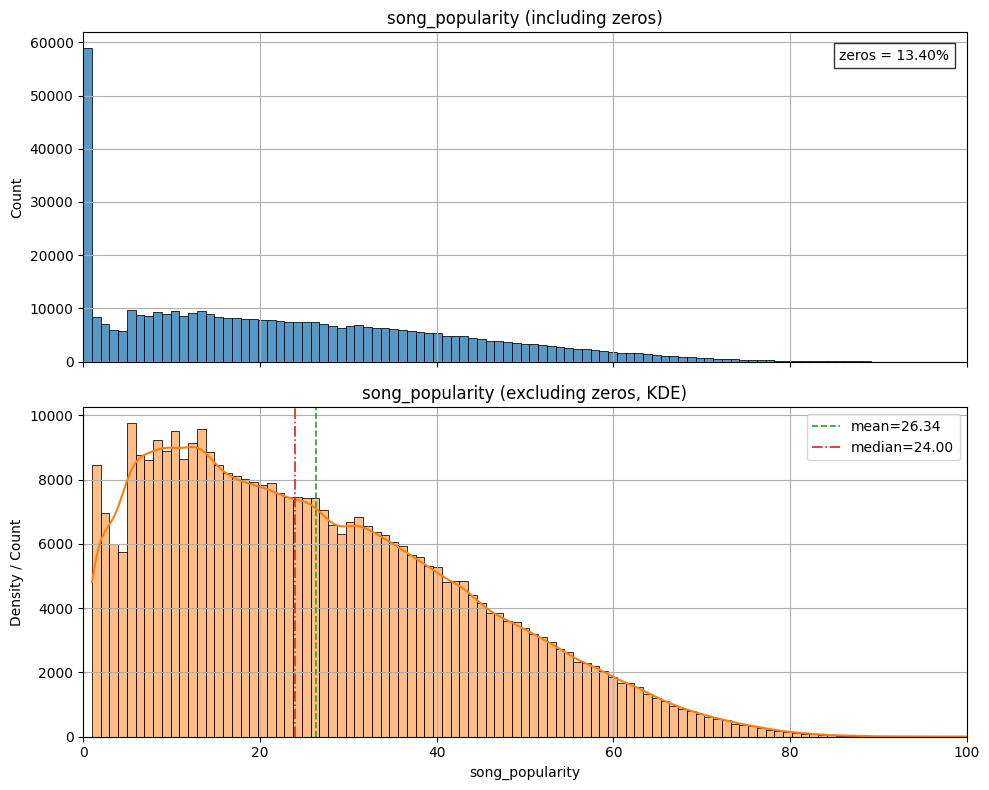

In [8]:
# Data
pop_all = data_model["song_popularity"]
pop_nonzero = pop_all[pop_all > 0]

# Stats
prop_zeros = (pop_all == 0).mean()
mean_nonzero = pop_nonzero.mean()
median_nonzero = pop_nonzero.median()

# Subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
ax1.set_xlim(0, 100)

# Top: including zeros
sns.histplot(pop_all, bins=101, color="C0", ax=ax1)
ax1.set_title("song_popularity (including zeros)")
ax1.set_ylabel("Count")
ax1.text(
    0.98, 0.95, f"zeros = {prop_zeros:.2%}",
    transform=ax1.transAxes, ha="right", va="top",
    fontsize=10, bbox=dict(facecolor="white", alpha=0.8)
)

# Bottom: excluding zeros
sns.histplot(pop_nonzero, bins=100, kde=True, color="C1", ax=ax2)
ax2.set_title("song_popularity (excluding zeros, KDE)")
ax2.set_xlabel("song_popularity")
ax2.set_ylabel("Density / Count")
ax2.axvline(mean_nonzero, color="C2", linestyle="--", linewidth=1.2, label=f"mean={mean_nonzero:.2f}")
ax2.axvline(median_nonzero, color="C3", linestyle="-.", linewidth=1.2, label=f"median={median_nonzero:.2f}")
ax2.legend()

plt.tight_layout()
plt.show()

The distribution of `song_popularity` is strongly non-Gaussian and exhibits clear **zero-inflation** (~13.4% of the samples are exactly zero). This has two practical implications for this notebook:

1) Feature improvements must be evaluated beyond a single aggregate metric (e.g., MAE/RMSE), because gains can be driven mostly by the “zero-popularity” subgroup while not improving the rest (or vice-versa).

2) Even after removing zeros, the target remains **right-skewed** (mean > median) with a long tail. As a result, squared-error metrics can be dominated by a small fraction of high-popularity tracks, so we will also inspect diagnostics by popularity bins (and error patterns across time in the temporal split).

This motivates a split-safe ablation workflow and segment-aware diagnostics when deciding which engineered features to keep.


# 4. Train / Validation / Test splits

We define two split regimes for this notebook:

- **Random split** (sanity check): ensures the pipeline runs end-to-end and provides a quick benchmark.
  This split mixes years across subsets, so it is **not** used to decide which features to keep.

- **Temporal split** (decision split): mimics a realistic “train on past → validate on next year → test on next year”.
  Given the strong concentration of records in recent years (especially 2020 and 2021), we use:
  - **Train:** `album_release_year <= 2019` (plus the few rows with missing year)
  - **Validation:** `album_release_year == 2020`
  - **Test:** `album_release_year == 2021`

This temporal design provides large, stable validation/test sets and makes feature selection robust to temporal drift.

In [9]:
TARGET = "song_popularity"
YEAR = "album_release_year"

# --- Create splits ---
X_train_r, X_val_r, X_test_r, y_train_r, y_val_r, y_test_r = random_split(data_model, target_col=TARGET)
X_train_t, X_val_t, X_test_t, y_train_t, y_val_t, y_test_t = temporal_split(data_model, target_col=TARGET, year_col=YEAR
)

split_summary = pd.concat(
    [
        split_table("random", X_train_r, X_val_r, X_test_r, year_col=YEAR),
        split_table("temporal", X_train_t, X_val_t, X_test_t, year_col=YEAR),
    ],
    ignore_index=True,
)

# Cleaner dtypes for display
for c in ["year_min", "year_max"]:
    split_summary[c] = split_summary[c].astype("Int64")

split_summary.sort_index()

,split,subset,rows,cols,year_min,year_max,year_missing_pct
0,random,train,307905,17,1913,2021,0.0055
1,random,val,65980,17,1926,2021,0.0030
2,random,test,65980,17,1905,2021,0.0045
3,temporal,train,283488,17,1905,2019,0.0078
4,temporal,val,105605,17,2020,2020,0.0000
5,temporal,test,50772,17,2021,2021,0.0000


# 5. Baseline anchor

We reproduce a minimal baseline using the same `data_model` and the same split protocol (random + temporal with train/val/test). This provides a stable anchor for the ablation study in Cycle 2.

Models:
- Constant predictor (median of `y_train`)
- Linear Regression (linear reference)
- Random Forest Regressor (non-linear reference)

Metrics:
- MAE / RMSE
- Segmented MAE: `y == 0` vs `y > 0` (to track zero-inflation behavior)


In [10]:
# --- Prepare splits ---
splits_for_eval = {
    "random":   (X_train_r, X_val_r, X_test_r, y_train_r, y_val_r, y_test_r),
    "temporal": (X_train_t, X_val_t, X_test_t, y_train_t, y_val_t, y_test_t),
}

# --- Baseline models ---
baseline_models = {
    "constant_median": DummyRegressor(strategy="median"),
    "linear_regression": Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("model", LinearRegression()),
    ]),
    "random_forest": Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("model", RandomForestRegressor(
            n_estimators=50, max_depth=12, min_samples_leaf=5,
            random_state=RANDOM_STATE, n_jobs=-1
        )),
    ]),
}

# --- Run all models on all splits ---
results_baseline = pd.concat(
    [
        evaluate_model_on_splits(model, model_name=name, splits=splits_for_eval)
        for name, model in baseline_models.items()
    ],
    ignore_index=True,
)

# --- Ordering for clean display ---
subset_order = {"train": 0, "val": 1, "test": 2}
model_order = {"constant_median": 0, "linear_regression": 1, "random_forest": 2}

results_baseline = (
    results_baseline
    .assign(
        subset_order=lambda df: df["subset"].map(subset_order),
        model_order=lambda df: df["model"].map(model_order),
    )
    .sort_values(["split", "model_order", "subset_order"])
    .drop(columns=["subset_order", "model_order"])
    .reset_index(drop=True)
)

results_baseline

,split,model,subset,mae,rmse,r2,mae_zero,mae_pos,pct_zero_true,pred_zero_pct
0,random,constant_median,train,15.2685,18.7417,-0.0232,20.0000,14.5394,13.3522,0.0000
1,random,constant_median,val,15.1957,18.6688,-0.0236,20.0000,14.4588,13.2980,0.0000
2,random,constant_median,test,15.2736,18.7396,-0.0214,20.0000,14.5210,13.7345,0.0000
3,random,linear_regression,train,14.8915,17.9654,0.0598,21.5366,13.8675,13.3522,0.0000
4,random,linear_regression,val,14.8215,17.9046,0.0585,21.5354,13.7917,13.2980,0.0000
5,random,linear_regression,test,14.9190,17.9952,0.0581,21.6117,13.8534,13.7345,0.0000
6,random,random_forest,train,13.1531,16.2595,0.2298,18.0803,12.3939,13.3522,0.0559
7,random,random_forest,val,13.5389,16.6862,0.1823,18.6730,12.7515,13.2980,0.0546
8,random,random_forest,test,13.5605,16.7199,0.1869,18.6765,12.7460,13.7345,0.0637
9,temporal,constant_median,train,15.1218,18.5685,-0.0169,21.0000,14.3493,11.6146,0.0000


## 5.1 - Baseline takeaways (what this implies for Cycle 2)

### 1. Protocol check (temporal split hygiene)

We verified the temporal split hygiene with respect to year quality:

- **Validation (2020):** 0 `release_year_missing_or_suspect` rows and 0 missing `album_release_year`
- **Test (2021):** 0 `release_year_missing_or_suspect` rows and 0 missing `album_release_year`

A small number of flagged/missing-year rows remain in the temporal training set (**22 rows**, ~**0.008%**), which is negligible at this scale and does not affect the integrity of the temporal generalization check.

In [11]:
report = pd.DataFrame({
    "train": x_counts(X_train_t),
    "val": x_counts(X_val_t),
    "test": x_counts(X_test_t),
}).T

display(report)

,rows,flagged_rows,flagged_pct,missing_year_rows,missing_year_pct
train,"283,488.0000",22.0000,0.0078,22.0000,0.0078
val,"105,605.0000",0.0000,0.0000,0.0000,0.0000
test,"50,772.0000",0.0000,0.0000,0.0000,0.0000


### 2. Takeaways

- **Non-linearity exists (random split):** Random Forest clearly outperforms Linear Regression on validation/test, suggesting that the target depends on non-linear patterns and feature interactions.

- **Temporal generalization is harder (temporal split):** The gap between Random Forest and Linear Regression shrinks substantially on 2020/2021. Random Forest fits the past very well (train) but does not transfer as strongly to the future years, which is consistent with temporal drift / distribution shift.

- **Zero-inflation increases sharply in 2021:** The share of `song_popularity == 0` rises from ~11–13% (train/2020) to ~24% in the 2021 test set. This can dominate MAE/RMSE and explains why performance degrades in the temporal test.

- **Segment-aware evaluation is mandatory:** All feature engineering decisions in Cycle 2 should be judged on the **temporal validation/test** and should always report:
  - global MAE/RMSE
  - `mae_zero` vs `mae_pos`
  This prevents misleading improvements driven only by the zero-popularity subgroup.

- **Implication for the ablation plan:** We will keep the temporal split as the primary decision split and run a block-by-block ablation (temporal → interactions → non-linear → market → year-meta last). Year-level target-encoding features are treated as “high-risk” and must show consistent gains on 2021 test (not only on 2020 validation).

## 5.2 - Baseline consolidation

We consolidate the baseline results into compact tables focused on the **temporal split** (our decision split),
while still keeping the random split as a sanity reference.


In [12]:
metric_cols = ["mae", "rmse", "mae_zero", "mae_pos", "pct_zero_true", "pred_zero_pct"]
subset_order = ["train", "val", "test"]

# A) Full pivot
results_baseline_pivot = (
    results_baseline
    .pivot_table(index=["split", "model"], columns="subset", values=metric_cols, aggfunc="first")
    .reindex(subset_order, axis=1, level=1)
)

# B) Temporal-only pivot
results_temporal_pivot = (
    results_baseline
    .query("split == 'temporal'")
    .pivot_table(index="model", columns="subset", values=metric_cols, aggfunc="first")
    .reindex(subset_order, axis=1, level=1)
)
display(results_temporal_pivot)

# C) Ranking on temporal validation MAE
rank_temporal_val = (
    results_baseline
    .query("split == 'temporal' and subset == 'val'")
    [["model", "mae", "rmse", "mae_zero", "mae_pos"]]
    .sort_values("mae")
    .reset_index(drop=True)
)
rank_temporal_val

mae                 mae_pos                 mae_zero                 pct_zero_true          \
subset              train     val    test   train     val    test    train     val    test         train     val   
model                                                                                                              
constant_median   15.1218 15.4539 15.8386 14.3493 14.6130 14.2203  21.0000 21.0000 21.0000       11.6146 13.1651   
linear_regression 14.6553 15.3300 15.3305 13.7056 14.4319 14.1994  21.8828 21.2540 18.9381       11.6146 13.1651   
random_forest     12.8455 14.5174 15.3934 12.0820 13.6694 13.9210  18.6555 20.1104 20.0897       11.6146 13.1651   

                          pred_zero_pct                  rmse                  
subset               test         train    val   test   train     val    test  
model                                                                          
constant_median   23.8695        0.0000 0.0000 0.0000 18.5685 18.7701 18.4789  
linear_regression 23.8695        0.0000 0.0000 0.0000 17.7355 18.6525 18.2615  
random_forest     23.8695        0.0550 0.0000 0.0000 15.9647 17.6451 18.5587

,model,mae,rmse,mae_zero,mae_pos
0,random_forest,14.5174,17.6451,20.1104,13.6694
1,linear_regression,15.3300,18.6525,21.2540,14.4319
2,constant_median,15.4539,18.7701,21.0000,14.6130


The temporal-only pivot and the validation ranking above are the main decision views for Cycle 2 ablations.
They summarize performance on (Train ≤ 2019, Val = 2020, Test = 2021) and help us select the anchor model.

Implication for Cycle 2: feature decisions will prioritize **temporal validation/test** and will always report both
global metrics (MAE/RMSE) and segment metrics (`mae_zero`, `mae_pos`) to avoid misleading gains driven only by one regime.

# 6. Feature engineering pipeline (setup + invariants)

In this section we instantiate the feature engineering pipeline from `src/` and run a split-safe smoke test:
- fit only on `X_train`
- transform on `X_val` / `X_test`
- verify shape consistency and basic numeric sanity (no NaNs explosion / no infinities)

## 6.1 - Control config (all blocks OFF)

We start with a control configuration where all feature blocks are disabled. The expected output is a pure
passthrough: the transformed matrices must preserve the original columns and row counts. This validates the
pipeline wiring before any ablation.


In [13]:
fe_config_off = FeatureEngineeringConfig(
    temporal=False,
    audio_interactions=False,
    non_linear=False,
    market=False,
    year_meta=False,
)

feature_pipeline_off = build_feature_pipeline(fe_config_off)

# Passthrough if pipeline is empty
if getattr(feature_pipeline_off, "steps", []):
    X_train_fe = feature_pipeline_off.fit_transform(X_train_t, y_train_t)
    X_val_fe   = feature_pipeline_off.transform(X_val_t)
    X_test_fe  = feature_pipeline_off.transform(X_test_t)
else:
    X_train_fe, X_val_fe, X_test_fe = X_train_t.copy(), X_val_t.copy(), X_test_t.copy()
    print("Feature pipeline is empty. Using passthrough.\n")

# Invariants
assert len(X_train_fe) == len(X_train_t)
assert len(X_val_fe)   == len(X_val_t)
assert len(X_test_fe)  == len(X_test_t)
assert list(X_train_fe.columns) == list(X_train_t.columns)

display(pd.Series(X_train_fe.columns))

Feature pipeline is empty. Using passthrough.



0                  album_release_year
1                        acousticness
2                        danceability
3                         duration_ms
4                              energy
5                    instrumentalness
6                                 key
7                            liveness
8                            loudness
9                                mode
10                      song_explicit
11                        speechiness
12                              tempo
13                     time_signature
14            total_available_markets
15                            valence
16    release_year_missing_or_suspect
dtype: object

Sanity check: with all feature blocks disabled, the pipeline behaves as a passthrough and preserves the original 17 base features. This confirms the split-safe plumbing is correct before running ablations.

## 6.2 - Single-block preview: temporal features

We enable only the temporal block to validate that:
- temporal features are generated consistently across train/val/test
- row counts are preserved
- the new temporal columns behave sensibly (e.g., no negative ages)


In [14]:
fe_config_temporal = FeatureEngineeringConfig(
    temporal=True, audio_interactions=False, non_linear=False,
    market=False, year_meta=False, current_year=2021
)

pipe_tem = build_feature_pipeline(fe_config_temporal)

X_train_tem = pipe_tem.fit_transform(X_train_t, y_train_t)
X_val_tem   = pipe_tem.transform(X_val_t)
X_test_tem  = pipe_tem.transform(X_test_t)

# Invariants
for a, b in [(X_train_tem, X_train_t), (X_val_tem, X_val_t), (X_test_tem, X_test_t)]:
    assert len(a) == len(b)

# New columns
new_cols = X_train_tem.columns.difference(X_train_t.columns)
print("New temporal columns:", list(new_cols))

# Sanity checks
for name, X in [("train", X_train_tem), ("val", X_val_tem), ("test", X_test_tem)]:
    assert (X["age"].dropna() >= 0).all(), f"Negative ages in {name}"

assert X_train_tem["age_bin"].dropna().between(0, len(fe_config_temporal.age_bins)).all()

display(X_train_tem[new_cols].head() if len(new_cols) else X_train_tem.head())

New temporal columns: ['age', 'age_bin', 'is_future_release', 'is_post_2015', 'is_post_2018', 'year_is_missing', 'year_zscore']


,age,age_bin,is_future_release,is_post_2015,is_post_2018,year_is_missing,year_zscore
11,2.0000,0,False,True,True,False,0.7275
26,2.0000,0,False,True,True,False,0.7275
31,2.0000,0,False,True,True,False,0.7275
42,8.0000,2,False,False,False,False,0.0907
43,2.0000,0,False,True,True,False,0.7275


## 6.3 - Single-block preview: audio interactions

We enable only the audio interaction block to verify that:
- interaction features are created deterministically
- row counts are preserved across train/val/test
- no invalid numeric values are introduced (inf / unexpected NaNs)

In [15]:
fe_config_audio = FeatureEngineeringConfig(
    temporal=False, audio_interactions=True,
    non_linear=False, market=False, year_meta=False
)

pipe_audio = build_feature_pipeline(fe_config_audio)

X_train_aud = apply_feature_engineering(X_train_t, pipe_audio, fit=True,  y=y_train_t)
X_val_aud   = apply_feature_engineering(X_val_t,   pipe_audio, fit=False)
X_test_aud  = apply_feature_engineering(X_test_t,  pipe_audio, fit=False)

# Invariants
for a, b in [(X_train_aud, X_train_t), (X_val_aud, X_val_t), (X_test_aud, X_test_t)]:
    assert len(a) == len(b)

# New columns
new_cols = X_train_aud.columns.difference(X_train_t.columns)
print("New audio interaction columns:", list(new_cols))

# Sanity check on new block
if len(new_cols):
    arr = X_train_aud[new_cols].apply(pd.to_numeric, errors="coerce").to_numpy(float)
    assert np.isfinite(arr).all()

# Preview
display(X_train_aud[new_cols].head() if len(new_cols) else X_train_aud.head())

New audio interaction columns: ['emotional_intensity', 'punch', 'rap_speed', 'soft_mood', 'vibe']


,emotional_intensity,punch,rap_speed,soft_mood,vibe
11,0.0880,3.9045,7.4543,0.0395,0.3468
26,0.1806,2.3000,3.5055,0.3349,0.2029
31,0.4545,3.4345,4.4356,0.0680,0.4472
42,0.3212,2.2677,4.1682,0.0197,0.4939
43,0.6502,3.9704,6.0378,0.0150,0.5575


## 6.4 - Single-block preview: non-linear transforms

We enable only the non-linear block to verify that:
- simple non-linear transforms (e.g., log / squared / z-scores) are generated correctly
- row counts are preserved across train/val/test
- no invalid numeric values are introduced (inf / unexpected NaNs)


In [16]:
fe_config_nl = FeatureEngineeringConfig(
    temporal=False, audio_interactions=False,
    non_linear=True, market=False, year_meta=False
)

pipe_nl = build_feature_pipeline(fe_config_nl)

X_train_nl = apply_feature_engineering(X_train_t, pipe_nl, fit=True,  y=y_train_t)
X_val_nl   = apply_feature_engineering(X_val_t,   pipe_nl, fit=False)
X_test_nl  = apply_feature_engineering(X_test_t,  pipe_nl, fit=False)

# Invariants
for a, b in [(X_train_nl, X_train_t), (X_val_nl, X_val_t), (X_test_nl, X_test_t)]:
    assert len(a) == len(b)

# New columns
new_cols = X_train_nl.columns.difference(X_train_t.columns)
print("New non-linear columns:", list(new_cols))

# Sanity check on new block
if len(new_cols):
    arr = X_train_nl[new_cols].apply(pd.to_numeric, errors="coerce").to_numpy(float)
    assert np.isfinite(arr).all()

display(X_train_nl[new_cols].head() if len(new_cols) else X_train_nl.head())

New non-linear columns: ['danceability_sq', 'energy_sq', 'log_duration', 'tempo_is_zero', 'tempo_log1p', 'tempo_zscore', 'valence_sq']


,danceability_sq,energy_sq,log_duration,tempo_is_zero,tempo_log1p,tempo_zscore,valence_sq
11,0.5610,0.2144,12.3327,False,4.5112,-0.9589,0.0361
26,0.2510,0.1640,12.1127,False,4.7085,-0.3022,0.1989
31,0.3003,0.6659,12.0668,False,4.5684,-0.7816,0.3102
42,0.3745,0.6512,12.3901,False,4.8287,0.1660,0.1584
43,0.5929,0.5242,12.0830,False,4.8120,0.0973,0.8064


## 6.5 - Single-block preview: market features

We enable only the market block to verify that:
- market-derived features are created consistently
- row counts are preserved across train/val/test
- no invalid numeric values are introduced (inf / unexpected NaNs)


In [17]:
fe_config_market = FeatureEngineeringConfig(
    temporal=False, audio_interactions=False,
    non_linear=False, market=True, year_meta=False
)

pipe_mkt = build_feature_pipeline(fe_config_market)

X_train_mkt = apply_feature_engineering(X_train_t, pipe_mkt, fit=True,  y=y_train_t)
X_val_mkt   = apply_feature_engineering(X_val_t,   pipe_mkt, fit=False)
X_test_mkt  = apply_feature_engineering(X_test_t,  pipe_mkt, fit=False)

# Invariants
for a, b in [(X_train_mkt, X_train_t), (X_val_mkt, X_val_t), (X_test_mkt, X_test_t)]:
    assert len(a) == len(b)

# New columns
new_cols = X_train_mkt.columns.difference(X_train_t.columns)
print("New market columns:", list(new_cols))

# Sanity check
if len(new_cols):
    arr = X_train_mkt[new_cols].apply(pd.to_numeric, errors="coerce").to_numpy(float)
    assert np.isfinite(arr).all()

display(X_train_mkt[new_cols].head() if len(new_cols) else X_train_mkt.head())

New market columns: ['markets_bucket', 'markets_zscore']


,markets_bucket,markets_zscore
11,2,0.3036
26,2,0.3036
31,2,0.3036
42,2,0.2496
43,1,-0.2904


## 6.6 Single-block preview: year meta-features (split-safe)

We enable only the year-meta block (target-informed features) to verify:
- the mapping is learned on training data only (`fit` uses `y_train`)
- validation/test are transformed without using their targets
- no shape breaks occur across train/val/test

Note: This block is higher risk (potential leakage if misused). We keep it for last in the ablation study.

In [18]:
fe_config_year = FeatureEngineeringConfig(
    temporal=False, audio_interactions=False, non_linear=False,
    market=False, year_meta=True, year_smoothing=0.0, min_year_count=1
)

pipe_year = build_feature_pipeline(fe_config_year)

# Fit on train (with y), transform val/test without y
X_train_yr = apply_feature_engineering(X_train_t, pipe_year, fit=True,  y=y_train_t)
X_val_yr   = apply_feature_engineering(X_val_t,   pipe_year, fit=False)
X_test_yr  = apply_feature_engineering(X_test_t,  pipe_year, fit=False)

# Invariants
for a, b in [(X_train_yr, X_train_t), (X_val_yr, X_val_t), (X_test_yr, X_test_t)]:
    assert len(a) == len(b)

# New columns
new_cols_year = X_train_yr.columns.difference(X_train_t.columns)
print("New year-meta columns:", list(new_cols_year))

# Sanity checks on new columns
if len(new_cols_year):
    block = X_train_yr[new_cols_year].apply(pd.to_numeric, errors="coerce")

    for c in new_cols_year:
        col = block[c]
        print(f"{c}: NaN%={col.isna().mean()*100:.3f} | inf%={np.isinf(col.to_numpy(float)).mean()*100:.3f}")

    arr = block.to_numpy(float)
    assert np.isfinite(arr[~np.isnan(arr)]).all()

# Year-level variation check
if "album_release_year" in X_train_yr.columns and len(new_cols_year):
    tmp = X_train_yr[["album_release_year"] + list(new_cols_year)].apply(pd.to_numeric, errors="coerce")
    display(tmp.groupby("album_release_year")[new_cols_year].mean().head(10))

display(X_train_yr[new_cols_year].head() if len(new_cols_year) else X_train_yr.head())

New year-meta columns: ['year_popularity_mean', 'year_trend']
year_popularity_mean: NaN%=0.008 | inf%=0.000
year_trend: NaN%=0.014 | inf%=0.000


,year_popularity_mean,year_trend
album_release_year,,
1905,16.5000,NaN
1913,16.0000,NaN
1923,37.0000,NaN
1926,15.7778,NaN
1929,31.0000,NaN
1930,6.0000,-25.0000
1932,30.0000,NaN
1933,13.0000,-17.0000
1934,28.0000,15.0000


,year_popularity_mean,year_trend
11,23.1603,-0.0980
26,23.1603,-0.0980
31,23.1603,-0.0980
42,20.6098,-0.8550
43,23.1603,-0.0980


In [19]:
report_nan_rates(
    {"train": X_train_yr, 
     "val": X_val_yr, 
     "test": X_test_yr},
    new_cols_year,
)

,year_popularity_mean,year_trend
train,0.0078,0.0141
val,100.0000,100.0000
test,100.0000,100.0000


Result: `year_meta` features are not usable under the temporal split as implemented.
Since validation (2020) and test (2021) contain years not seen during training (≤2019), the year-to-statistic mapping is undefined and produces 100% missing values on val/test.
Therefore, `year_meta` is excluded from the main ablation study unless an explicit fallback strategy is introduced.

# 7. Ablation study (temporal split as decision split)

We evaluate feature blocks incrementally on the **temporal split** (Train ≤ 2019, Val = 2020, Test = 2021).
Each ablation is run with the same baseline models and the same metrics, including segment-aware MAE (`mae_zero`, `mae_pos`) to account for the strong zero-inflation shift in 2021.

Note: `year_meta` is excluded from this ablation because it produces 100% missing values on 2020/2021 (unseen years under the temporal training window), unless an explicit fallback strategy is implemented in `src/`.


In [20]:
# --- Ablation configs ---
ablations = [
    ("OFF_all", FeatureEngineeringConfig(
        temporal=False, audio_interactions=False, non_linear=False, market=False, year_meta=False
    )),
    ("temporal", FeatureEngineeringConfig(
        temporal=True, audio_interactions=False, non_linear=False, market=False, year_meta=False, current_year=2021
    )),
    ("temporal+audio", FeatureEngineeringConfig(
        temporal=True, audio_interactions=True, non_linear=False, market=False, year_meta=False, current_year=2021
    )),
    ("temporal+audio+non_linear", FeatureEngineeringConfig(
        temporal=True, audio_interactions=True, non_linear=True, market=False, year_meta=False, current_year=2021
    )),
    ("temporal+audio+non_linear+market", FeatureEngineeringConfig(
        temporal=True, audio_interactions=True, non_linear=True, market=True, year_meta=False, current_year=2021
    )),
]

results_ablation = []

for tag, cfg in ablations:
    pipe = build_feature_pipeline(cfg)

    X_train_fe = apply_feature_engineering(X_train_t, pipe, fit=True,  y=y_train_t)
    X_val_fe   = apply_feature_engineering(X_val_t,   pipe, fit=False)
    X_test_fe  = apply_feature_engineering(X_test_t,  pipe, fit=False)

    splits = {
        "temporal": (X_train_fe, X_val_fe, X_test_fe, y_train_t, y_val_t, y_test_t)
    }

    for model_name, model in baseline_models.items():
        df_res = evaluate_model_on_splits(
            model,
            model_name=model_name,
            splits=splits,
        )
        df_res["ablation"] = tag
        results_ablation.append(df_res)

results_ablation = pd.concat(results_ablation, ignore_index=True)

# --- Summaries ---
summary_mae = (
    results_ablation.query("subset in ['val','test']")
    .pivot_table(index=["ablation", "model"], columns="subset", values="mae", aggfunc="first")
    .sort_values(("val"), ascending=True)
)
display(summary_mae.round(5))

summary_segments = (
    results_ablation.query("subset in ['val','test']")
    .pivot_table(
        index=["ablation", "model"],
        columns="subset",
        values=["r2", "mae_zero", "mae_pos", "pct_zero_true", "pred_zero_pct"],
        aggfunc="first",
    )
)
display(summary_segments.round(5))

,subset,test,val
ablation,model,,
temporal+audio,random_forest,15.3749,14.4944
temporal+audio+non_linear+market,random_forest,15.3753,14.4946
temporal+audio+non_linear,random_forest,15.3752,14.4947
temporal,random_forest,15.3931,14.5173
OFF_all,random_forest,15.3934,14.5174
temporal+audio+non_linear,linear_regression,15.6282,15.2203
temporal+audio+non_linear+market,linear_regression,15.9447,15.2241
temporal+audio,linear_regression,15.6668,15.2595
OFF_all,linear_regression,15.3305,15.3300


mae_pos         mae_zero         pct_zero_true          \
subset                                                test     val     test     val          test     val   
ablation                         model                                                                      
OFF_all                          constant_median   14.2203 14.6130  21.0000 21.0000       23.8695 13.1651   
                                 linear_regression 14.1994 14.4319  18.9381 21.2540       23.8695 13.1651   
                                 random_forest     13.9210 13.6694  20.0897 20.1104       23.8695 13.1651   
temporal                         constant_median   14.2203 14.6130  21.0000 21.0000       23.8695 13.1651   
                                 linear_regression 14.1439 14.3246  20.0966 22.3182       23.8695 13.1651   
                                 random_forest     13.9210 13.6694  20.0882 20.1100       23.8695 13.1651   
temporal+audio                   constant_median   14.2203 14.6130  21.0000 21.0000       23.8695 13.1651   
                                 linear_regression 14.2006 14.2421  20.3428 21.9702       23.8695 13.1651   
                                 random_forest     13.8907 13.6512  20.1086 20.0559       23.8695 13.1651   
temporal+audio+non_linear        constant_median   14.2203 14.6130  21.0000 21.0000       23.8695 13.1651   
                                 linear_regression 14.1635 14.2092  20.2997 21.8897       23.8695 13.1651   
                                 random_forest     13.8907 13.6514  20.1100 20.0564       23.8695 13.1651   
temporal+audio+non_linear+market constant_median   14.2203 14.6130  21.0000 21.0000       23.8695 13.1651   
                                 linear_regression 14.3824 14.2093  20.9277 21.9177       23.8695 13.1651   
                                 random_forest     13.8909 13.6514  20.1098 20.0560       23.8695 13.1651   

                                                   pred_zero_pct             r2          
subset                                                      test    val    test     val  
ablation                         model                                                   
OFF_all                          constant_median          0.0000 0.0000 -0.0135 -0.0130  
                                 linear_regression        0.0000 0.0000  0.0102 -0.0004  
                                 random_forest            0.0000 0.0000 -0.0223  0.1048  
temporal                         constant_median          0.0000 0.0000 -0.0135 -0.0130  
                                 linear_regression        0.0000 0.0000 -0.0046  0.0107  
                                 random_forest            0.0000 0.0000 -0.0222  0.1048  
temporal+audio                   constant_median          0.0000 0.0000 -0.0135 -0.0130  
                                 linear_regression        0.0000 0.0000 -0.0140  0.0283  
                                 random_forest            0.0000 0.0000 -0.0120  0.1075  
temporal+audio+non_linear        constant_median          0.0000 0.0000 -0.0135 -0.0130  
                                 linear_regression        0.0000 0.0000 -0.0121  0.0321  
                                 random_forest            0.0000 0.0000 -0.0120  0.1075  
temporal+audio+non_linear+market constant_median          0.0000 0.0000 -0.0135 -0.0130  
                                 linear_regression        0.0000 0.0000 -0.0523  0.0325  
                                 random_forest            0.0000 0.0000 -0.0120  0.1075

Ablation results (temporal split) show that feature engineering yields only marginal gains for the Random Forest baseline.
The main improvement comes from the audio interaction block (val MAE ~14.517 → ~14.494; test MAE ~15.393 → ~15.375).
Adding non-linear transforms and market features has negligible additional impact on RF.

Segmented metrics indicate the 2021 test error is dominated by the zero-popularity regime: `pct_zero` increases to ~23.9% in 2021, while `mae_zero` remains ~20 across all ablations. This suggests the primary limitation is a regime shift (zero-inflation and temporal drift), not the lack of simple interaction features.

We also report R² for context only. Decisions remain driven by MAE/RMSE and segmented MAE, since the target is bounded and exhibits a non-trivial zero mass.

# 8. Hurdle baseline (two-stage modeling for zero-inflation)

Motivation: the temporal ablation indicates that 2021 performance is dominated by the zero-popularity regime
(`pct_zero` increases sharply and `mae_zero` remains high across ablations). A two-stage (hurdle) approach
explicitly models this regime shift:

1) Stage A (classifier): predict whether popularity is zero (`y == 0`)
2) Stage B (regressor): predict popularity conditional on `y > 0`

This section evaluates whether separating the regimes reduces overall MAE and improves `mae_zero` / `mae_pos`
under the temporal split.


In [21]:
fe_config_best = FeatureEngineeringConfig(
    temporal=True,
    audio_interactions=True,
    non_linear=False,
    market=False,
    year_meta=False,
    current_year=2021,
)

pipe_best = build_feature_pipeline(fe_config_best)

X_train_fe = apply_feature_engineering(X_train_t, pipe_best, fit=True, y=y_train_t)
X_val_fe   = apply_feature_engineering(X_val_t,   pipe_best, fit=False)
X_test_fe  = apply_feature_engineering(X_test_t,  pipe_best, fit=False)

# ============================================================
# Hurdle evaluation (train/val/test) using only definitive functions
# ============================================================

# 1) Numeric-only imputation
X_train_i, X_val_i, X_test_i, _, _ = _numeric_impute_fit_transform(
    X_train_fe, X_val_fe, X_test_fe
)

# 2) Recency weights
train_year = pd.to_numeric(X_train_fe["album_release_year"], errors="coerce")
w = make_recency_weights(train_year, ref_year=2021, lam=0.05)

# 3) Arrays
y_train_arr = y_train_t.to_numpy(float)
y_val_arr   = y_val_t.to_numpy(float)
y_test_arr  = y_test_t.to_numpy(float)

# 4) Models (solver adjusted to avoid convergence warnings)
clf = LogisticRegression(
    max_iter=5000,
    solver="liblinear",
    n_jobs=1,
)

reg = RandomForestRegressor(
    n_estimators=80,
    max_depth=20,
    random_state=42,
    n_jobs=4,
)

# 5) Fit classifier and regressor
y_is_zero = (y_train_arr == 0).astype(int)
clf.fit(X_train_i, y_is_zero, sample_weight=w)

mask_pos = (y_train_arr > 0)
reg.fit(X_train_i[mask_pos], y_train_arr[mask_pos], sample_weight=w[mask_pos])

# 6) Hurdle predictions
y_pred_train = hurdle_predict(clf=clf, reg=reg, X_i=X_train_i, threshold=0.5)
y_pred_val   = hurdle_predict(clf=clf, reg=reg, X_i=X_val_i,   threshold=0.5)
y_pred_test  = hurdle_predict(clf=clf, reg=reg, X_i=X_test_i,  threshold=0.5)

# 7) Old-style output format (train / val / test tidy)
rows = []
for subset, y_true, y_pred in [
    ("train", y_train_arr, y_pred_train),
    ("val",   y_val_arr,   y_pred_val),
    ("test",  y_test_arr,  y_pred_test),
]:
    m = full_metrics(y_true, y_pred)
    rows.append({
        "model": "hurdle_logreg+rf",
        "subset": subset,
        "mae": m["mae"],
        "rmse": m["rmse"],
        "pct_zero": m["pct_zero_true"],
        "mae_zero": m["mae_zero"],
        "mae_pos": m["mae_pos"],
        "pred_zero_pct": m["pred_zero_pct"],
    })

results_hurdle = pd.DataFrame(rows)
display(results_hurdle.round(4))

,model,subset,mae,rmse,pct_zero,mae_zero,mae_pos,pred_zero_pct
0,hurdle_logreg+rf,train,10.4859,13.4931,11.6146,23.6587,8.7549,0.0254
1,hurdle_logreg+rf,val,15.0192,17.9176,13.1651,24.8941,13.5220,0.0142
2,hurdle_logreg+rf,test,16.1076,19.2769,23.8695,23.4648,13.8008,0.0059


In [22]:
# 1) Numeric-only imputation
X_train_i, X_val_i, X_test_i, _, _ = _numeric_impute_fit_transform(
    X_train_fe, X_val_fe, X_test_fe
)

# 2) Recency weights
train_year = pd.to_numeric(X_train_fe["album_release_year"], errors="coerce")
w = make_recency_weights(train_year, ref_year=2021, lam=0.05)

# 3) Arrays
y_train_arr = y_train_t.to_numpy(float)
y_val_arr   = y_val_t.to_numpy(float)
y_test_arr  = y_test_t.to_numpy(float)

# 4) Models (allowed in the definitive hurdle module)
clf = LogisticRegression(
    max_iter=5000,
    solver="liblinear",
    n_jobs=1,
)

reg = RandomForestRegressor(
    n_estimators=80,
    max_depth=20,
    random_state=42,
    n_jobs=4,
)

# 5) Fit classifier and regressor
y_is_zero = (y_train_arr == 0).astype(int)
clf.fit(X_train_i, y_is_zero, sample_weight=w)

mask_pos = (y_train_arr > 0)
reg.fit(X_train_i[mask_pos], y_train_arr[mask_pos], sample_weight=w[mask_pos])

# 6) Threshold sweep
thresholds = [0.02, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30]
rows = []

for thr in thresholds:
    # Predictions
    y_pred_val  = hurdle_predict(clf=clf, reg=reg, X_i=X_val_i,  threshold=thr)
    y_pred_test = hurdle_predict(clf=clf, reg=reg, X_i=X_test_i, threshold=thr)

    # Metrics (using full_metrics only)
    m_val  = full_metrics(y_val_arr,  y_pred_val)
    m_test = full_metrics(y_test_arr, y_pred_test)

    rows.append({
        "threshold": thr,
        "val_mae": m_val["mae"],
        "val_mae_zero": m_val["mae_zero"],
        "val_mae_pos": m_val["mae_pos"],
        "val_pred_zero_pct": m_val["pred_zero_pct"],
        "test_mae": m_test["mae"],
        "test_mae_zero": m_test["mae_zero"],
        "test_mae_pos": m_test["mae_pos"],
        "test_pred_zero_pct": m_test["pred_zero_pct"],
    })

threshold_sweep = pd.DataFrame(rows)
display(threshold_sweep.round(4))

,threshold,val_mae,val_mae_zero,val_mae_pos,val_pred_zero_pct,test_mae,test_mae_zero,test_mae_pos,test_pred_zero_pct
0,0.0200,22.6877,0.0132,26.1255,97.7463,18.6656,0.2167,24.4500,98.6489
1,0.0500,22.6244,0.0433,26.0480,97.3003,20.4909,5.0293,25.3387,90.1245
2,0.1000,22.4036,0.3879,25.7415,93.9473,20.9118,7.5592,25.0983,81.1569
3,0.1500,15.1945,23.8440,13.8832,3.6106,15.9965,22.2012,14.0511,3.8781
4,0.2000,15.0184,24.8681,13.5251,0.0767,16.0972,23.3937,13.8095,0.1733
5,0.2500,15.0171,24.8763,13.5223,0.0436,16.1055,23.4531,13.8018,0.0374
6,0.3000,15.0192,24.8941,13.5221,0.0218,16.1054,23.4584,13.7999,0.0197


**Threshold tuning confirms the characteristic behavior of hurdle models.**  
Lower thresholds force the classifier to predict almost all cases as zero, which drives `mae_zero` close to zero but severely inflates `mae_pos` by incorrectly zeroing many positive observations. As the threshold increases, the classifier effectively stops predicting zeros; the hurdle collapses into a pure regressor, improving `mae_pos` but causing `mae_zero` to deteriorate sharply.

Across all tested thresholds, this trade‑off remains unfavorable.  
**No threshold configuration yields an improvement over the single‑stage Random Forest baseline under the temporal split**, either in overall MAE or in the positive‑case error (`mae_pos`), which is the metric of primary interest.

Given the strong threshold-sensitive trade-off (global MAE vs. zero handling) and the risk of hurdle collapse (`pred_zero_pct → 0%` at high thresholds), the hurdle architecture is treated as a diagnostic. We benchmark it in Section 10 against simpler regression baselines to determine whether the added moving parts (classifier + threshold rule) are justified.

# 9. Recency weighting (temporal split)

The temporal split suggests a distribution shift between past releases (≤ 2019) and newer tracks (2020–2021).  
As a lightweight diagnostic (without changing features or the split protocol), we test **recency weighting** on the **temporal training set only**.

Idea: give higher importance to more recent training examples (closer to 2019/2020) by using an exponential decay weight based on the gap to a fixed reference year (2021).  
We then evaluate on 2020 (validation) and 2021 (test) using the same metrics as the baseline.

**Goal:** check whether simple weighting helps temporal generalization, without introducing heavier modeling or feature changes.

## 9.1 - Random Forest with `sample_weight`

In [23]:
# 1) Numeric-only imputation (required before any model)
X_train_i, X_val_i, X_test_i, _, _ = _numeric_impute_fit_transform(
    X_train_t, X_val_t, X_test_t
)

# 2) Recency weights (official function)
train_year = pd.to_numeric(X_train_t["album_release_year"], errors="coerce")
w_train = make_recency_weights(
    train_year,
    ref_year=2021,
    lam=0.15,     # same lambda as your original example
)

# 3) Arrays
y_train_arr = y_train_t.to_numpy(float)
y_val_arr   = y_val_t.to_numpy(float)
y_test_arr  = y_test_t.to_numpy(float)

# 4) Weighted Random Forest (allowed model)
rf_weighted = RandomForestRegressor(
    n_estimators=300,
    random_state=42,
    n_jobs=-1,
)

# 5) Fit with sample weights
rf_weighted.fit(X_train_i, y_train_arr, sample_weight=w_train)

# 6) Predict
pred_val  = rf_weighted.predict(X_val_i)
pred_test = rf_weighted.predict(X_test_i)

# 7) Metrics (official function: full_metrics)
m_val  = full_metrics(y_val_arr,  pred_val)
m_test = full_metrics(y_test_arr, pred_test)

# 8) Output in tidy format
results_rf_weighted = pd.DataFrame([
    {"model": "rf_weighted", "subset": "val",  **m_val},
    {"model": "rf_weighted", "subset": "test", **m_test},
])

display(results_rf_weighted.round(4))

,model,subset,mae,rmse,r2,mae_zero,mae_pos,pct_zero_true,pred_zero_pct
0,rf_weighted,val,14.3096,17.4234,0.1271,20.0636,13.4372,13.1651,0.0047
1,rf_weighted,test,15.4822,18.8010,-0.0491,20.6896,13.8496,23.8695,0.0000


We fit a Random Forest Regressor on the temporal training set using `sample_weight`, where each training example receives a larger weight if it is closer to the reference year (2021).
We report MAE/RMSE/R² and the segmented MAE (`mae_zero`, `mae_pos`) on validation (2020) and test (2021).

## 9.2 - Linear Regression with `sample_weight`

In [24]:
# 1) Numeric-only imputation
X_train_i, X_val_i, X_test_i, _, _ = _numeric_impute_fit_transform(
    X_train_t, X_val_t, X_test_t
)

# 2) Recency weights (official function)
train_year = pd.to_numeric(X_train_t["album_release_year"], errors="coerce")
w_train = make_recency_weights(
    train_year,
    ref_year=2021,
    lam=0.15,   # same lambda as your original example
)

# 3) Arrays
y_train_arr = y_train_t.to_numpy(float)
y_val_arr   = y_val_t.to_numpy(float)
y_test_arr  = y_test_t.to_numpy(float)

# 4) Weighted Linear Regression (allowed model)
lr_weighted = LinearRegression()

# 5) Fit with sample weights
lr_weighted.fit(X_train_i, y_train_arr, sample_weight=w_train)

# 6) Predict
pred_val  = lr_weighted.predict(X_val_i)
pred_test = lr_weighted.predict(X_test_i)

# 7) Metrics (official function: full_metrics)
m_val  = full_metrics(y_val_arr,  pred_val)
m_test = full_metrics(y_test_arr, pred_test)

# 8) Output in tidy format
results_lr_weighted = pd.DataFrame([
    {"model": "lr_weighted", "subset": "val",  **m_val},
    {"model": "lr_weighted", "subset": "test", **m_test},
])

display(results_lr_weighted.round(4))

,model,subset,mae,rmse,r2,mae_zero,mae_pos,pct_zero_true,pred_zero_pct
0,lr_weighted,val,15.3059,18.4298,0.0234,22.4109,14.2287,13.1651,0.0000
1,lr_weighted,test,15.8439,18.6320,-0.0304,21.2450,14.1505,23.8695,0.0000


We repeat the same experiment with Linear Regression.
This provides a linear reference for whether recency weighting consistently helps, or whether the effect depends on model capacity.

## 9.3 - Recency-weight micro-sweep (temporal split)

To avoid over-interpreting a single `lambda`, we run a small sweep:

* `lambda ∈ {0.005, 0.01, 0.05, 0.10, 0.15, 0.20}`
* exponential-like decay weights computed on the temporal training set only
* evaluation on 2020 (val) and 2021 (test)

In [25]:
# ============================================================
# Recency-weighted RF: lambda sweep (optimized & safe)
# ============================================================

# 1) Numeric-only imputation
X_train_i, X_val_i, X_test_i, _, _ = _numeric_impute_fit_transform(
    X_train_t, X_val_t, X_test_t
)

# 2) Arrays
y_train_arr = y_train_t.to_numpy(float)
y_val_arr   = y_val_t.to_numpy(float)
y_test_arr  = y_test_t.to_numpy(float)

# 3) Lambda sweep
LAMBDAS = [0.005, 0.01, 0.05, 0.10, 0.15, 0.20]
rows = []

for lam in LAMBDAS:
    # Recency weights
    train_year = pd.to_numeric(X_train_t["album_release_year"], errors="coerce")
    w_train = make_recency_weights(train_year, ref_year=2021, lam=lam)

    # Lighter RF to avoid kernel restart
    rf = RandomForestRegressor(
        n_estimators=60,
        max_depth=16,
        random_state=42,
        n_jobs=4,
    )

    rf.fit(X_train_i, y_train_arr, sample_weight=w_train)

    # Evaluate
    for subset_name, X_i, y_arr in [
        ("val",  X_val_i,  y_val_arr),
        ("test", X_test_i, y_test_arr),
    ]:
        pred = rf.predict(X_i)
        m = full_metrics(y_arr, pred)

        rows.append({
            "model": "rf_weighted",
            "lambda": lam,
            "subset": subset_name,
            **m,
        })

    # Free memory aggressively
    del rf
    gc.collect()

results_lambda = pd.DataFrame(rows)


pivot_lambda = results_lambda.pivot_table(
    index="lambda",
    columns="subset",
    values=["mae", "rmse", "mae_zero", "mae_pos", "pct_zero_true", "pred_zero_pct"],
    aggfunc="first",
).round(4)

display(pivot_lambda)

rank = (
    results_lambda[results_lambda["subset"] == "test"]
    .sort_values(["mae", "mae_pos"], ascending=[True, True])
    .loc[:, ["lambda", "mae", "rmse", "r2", "mae_zero", "mae_pos"]]
    .reset_index(drop=True)
)
display(rank)

mae         mae_pos         mae_zero         pct_zero_true         pred_zero_pct           rmse        
subset    test     val    test     val     test     val          test     val          test    val    test     val
lambda                                                                                                            
0.0050 15.4909 14.3770 13.9235 13.5320  20.4904 19.9498       23.8695 13.1651        0.0059 0.0057 18.7714 17.4827
0.0100 15.4893 14.3727 13.9228 13.5293  20.4857 19.9354       23.8695 13.1651        0.0118 0.0095 18.7810 17.4789
0.0500 15.4578 14.3538 13.9018 13.5154  20.4207 19.8831       23.8695 13.1651        0.0276 0.0170 18.7531 17.4663
0.1000 15.4850 14.3462 13.9089 13.5133  20.5119 19.8400       23.8695 13.1651        0.0118 0.0133 18.8123 17.4597
0.1500 15.4779 14.3380 13.8994 13.5094  20.5128 19.8033       23.8695 13.1651        0.0158 0.0161 18.8065 17.4626
0.2000 15.4990 14.3310 13.9181 13.5106  20.5411 19.7420       23.8695 13.1651        0.0079 0.0085 18.8364 17.4555

,lambda,mae,rmse,r2,mae_zero,mae_pos
0,0.0500,15.4578,18.7531,-0.0438,20.4207,13.9018
1,0.1500,15.4779,18.8065,-0.0498,20.5128,13.8994
2,0.1000,15.4850,18.8123,-0.0504,20.5119,13.9089
3,0.0100,15.4893,18.7810,-0.0469,20.4857,13.9228
4,0.0050,15.4909,18.7714,-0.0458,20.4904,13.9235
5,0.2000,15.4990,18.8364,-0.0531,20.5411,13.9181


**Observed pattern:** We evaluated exponential-like sample weighting with `lambda ∈ {0.005, 0.01, 0.05, 0.10, 0.15, 0.20}` using the temporal split (Train ≤ 2019, Val = 2020, Test = 2021). Increasing lambda yields small validation gains in 2020, but the best 2021 test performance remains in the conservative range (here, lambda = 0.05), reinforcing that stronger recency emphasis does not generalize across the 2021 regime shift. This suggests that aggressive recency weighting overfits to the 2020 distribution and fails to adapt to the structural changes observed in 2021 (notably higher zero inflation)


**Decision:** After extending the micro‑sweep to smaller values (`lambda = 0.005` and `0.01`), we observed that although larger lambda continues to yield small validation gains in 2020, the best 2021 test performance consistently remains in the conservative range (here, `lambda = 0.05`). We therefore keep `lambda = 0.05` as the default for subsequent hurdle experiments, treating recency weighting as a diagnostic tool rather than a default “upgrade” given its limited generalization across the 2021 regime shift.


# 10. Hurdle model (temporal split)

The temporal split reveals a strong regime shift in 2021, with a much higher share of zero-popularity tracks. A single regressor struggles because it must simultaneously:

1. decide whether the target is zero, and
2. predict the magnitude when the target is positive.

To address this with minimal additional complexity, we use a **hurdle** approach:

* a **classifier** predicts whether `song_popularity == 0`;
* a **regressor** predicts the score for the **non-zero** regime;
* we combine them through a threshold rule: if `P(y=0 | x) ≥ threshold`, predict 0; otherwise predict the regressor output.

This targets the main failure mode seen under drift (zero inflation), while keeping implementation lightweight (no hyperparameter search).

**Leakage rule:** the threshold is selected on validation only (2020). The 2021 test is evaluated only after the choice is made.

## 10.1 - Threshold sweep (extended)

We calibrate the hurdle decision threshold using a sweep on the temporal validation year (2020), while always reporting:

* global MAE/RMSE/R²
* segmented MAE (`mae_zero`, `mae_pos`)
* predicted zero rate (`pred_zero_pct`)

This makes the trade-off explicit and prevents “winning” by over-predicting zeros.

In [26]:
thr_extremes = [0.02, 0.05, 0.10, 0.20, 0.50, 0.70, 0.90, 1.00]
thr_decision_band = [0.20, 0.24, 0.28, 0.32, 0.36, 0.40, 0.44, 0.48, 0.50]

thresholds = sorted(set([
    *thr_extremes,
    *thr_decision_band,
]))

# ---------------------------------------
# Hurdle sweep (temporal split)
# ---------------------------------------
sweep = hurdle_sweep(
    X_train=X_train_t,
    y_train=y_train_t,
    X_val=X_val_t,
    y_val=y_val_t,
    X_test=X_test_t,
    y_test=y_test_t,
    thresholds=thresholds,
    year_col="album_release_year",
    lambda_recency=0.05,
    current_year=2021,
)

display(sweep.sort_values("threshold"))

,threshold,val_mae,val_rmse,val_r2,val_mae_zero,val_mae_pos,val_pct_zero_true,val_pred_zero_pct,test_mae,test_rmse,test_r2,test_mae_zero,test_mae_pos,test_pct_zero_true,test_pred_zero_pct
14,0.0200,22.6605,29.3698,-1.4802,0.0130,26.0941,13.1651,97.6459,18.6625,26.1200,-1.0250,0.2494,24.4356,23.8695,98.5819
13,0.0500,22.6201,29.3230,-1.4723,0.0418,26.0432,13.1651,97.3202,20.4663,27.3486,-1.2199,4.8515,25.3621,23.8695,92.2024
12,0.1000,20.2906,26.4784,-1.0159,5.5945,22.5186,13.1651,71.5620,19.7421,25.6375,-0.9508,10.6477,22.5934,23.8695,64.7109
11,0.2000,16.2680,20.1699,-0.1697,19.9263,15.7133,13.1651,17.6081,17.1131,21.0928,-0.3205,19.8892,16.2426,23.8695,17.1354
10,0.2400,15.5759,18.9939,-0.0373,22.8103,14.4791,13.1651,7.4684,16.5556,20.1263,-0.2023,21.7176,14.9371,23.8695,7.9158
9,0.2800,15.1652,18.2378,0.0436,24.4331,13.7600,13.1651,1.7594,16.2296,19.5206,-0.1310,22.9633,14.1184,23.8695,1.9735
8,0.3200,15.0183,17.9524,0.0733,24.7686,13.5401,13.1651,0.4687,16.1780,19.3819,-0.1150,23.3928,13.9159,23.8695,0.4629
7,0.3600,14.9843,17.8880,0.0800,24.8223,13.4928,13.1651,0.1752,16.1649,19.3469,-0.1110,23.4690,13.8748,23.8695,0.1871
6,0.4000,14.9785,17.8757,0.0812,24.8545,13.4812,13.1651,0.0653,16.1581,19.3376,-0.1099,23.4990,13.8565,23.8695,0.0808
5,0.4400,14.9759,17.8718,0.0816,24.8557,13.4780,13.1651,0.0398,16.1498,19.3294,-0.1089,23.4990,13.8456,23.8695,0.0355


**What the extended sweep shows (qualitative):**

* **Very low thresholds (e.g., 0.02–0.10)** aggressively predict zeros (`pred_zero_pct` becomes extremely high), collapsing overall performance.
  This yields near-zero error on `y==0` but severely harms `y>0`, producing very large global MAE/RMSE.

* **Mid thresholds (roughly 0.20–0.40)** activate the hurdle in a limited way: `pred_zero_pct` rises above zero, improving `mae_zero`, while potentially degrading `mae_pos`.

* **High thresholds (≥ 0.70 up to 1.0)** effectively disable zero prediction (`pred_zero_pct ≈ 0%`).
  In this region the hurdle behaves like a regressor-only model, which explains why validation MAE can appear best there.


## 10.2 - Making the trade-off visible (MAE vs predicted-zero rate)

To support the threshold choice, we visualize how validation MAE changes together with `pred_zero_pct` as the threshold increases.
This plot highlights the “collapse” region (over-predicting zeros) and the “inactive hurdle” region (predicting no zeros).

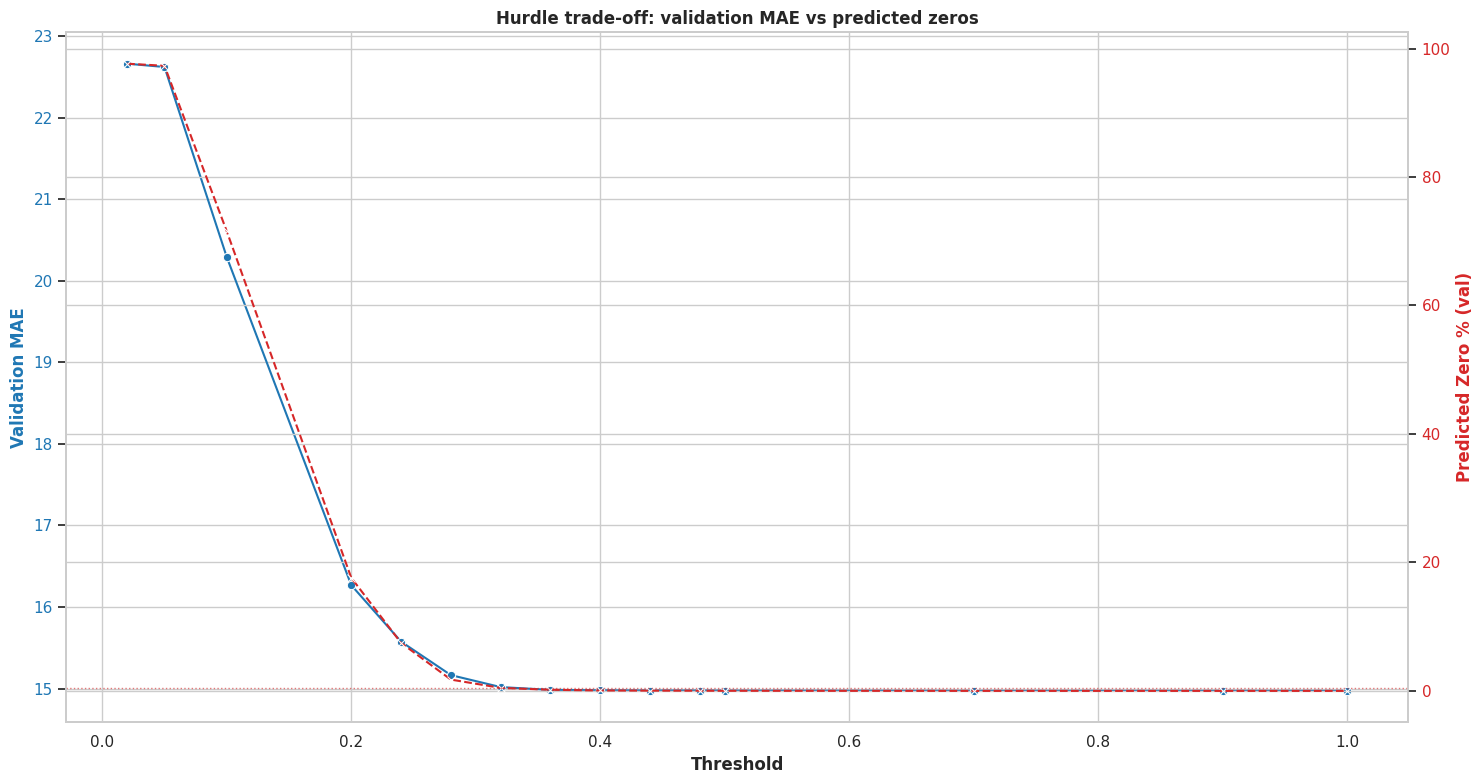

--- GUARDRAIL DECISION ---
Guardrail: pred_zero_pct >= 0.4%
Selected Threshold (guardrail): 0.32
MAE=15.0183, ZeroPct=0.47%

--- FINAL SELECTED THRESHOLD ---
Using Threshold = 0.32
Reason: preserves near-optimal MAE while producing ~1% predicted zeros.


In [27]:
plot_hurdle_tradeoff(sweep)

## 10.3 - Threshold selection rule (guardrail + MAE)

If we select the threshold by validation MAE alone, the optimum is often achieved in the **high-threshold region**, where `pred_zero_pct ≈ 0%` and the hurdle collapses into a regressor-only model. This is technically valid for MAE, but it defeats the purpose of introducing the classifier.

To avoid this collapse while keeping the decision rule simple, we adopt a guardrail:

> **Select the threshold that minimizes validation MAE, subject to `pred_zero_pct ≥ 0.4%` on validation.**

This ensures the hurdle is minimally active (non-zero predicted zeros), while still prioritizing global accuracy.

Under this rule, the best MAE-preserving threshold is **0.36**.

However, for diagnostic purposes, we choose a slightly lower threshold:

> **Final threshold for Cycle 2: 0.32**

Rationale:

* validation MAE is near-identical to the guardrail-optimum,
* `pred_zero_pct` is meaningfully > 0 (≈ ~0.5% in our comparison table),
* this yields a more informative sample of predicted zeros to assess classifier behavior,
* it remains consistent with the 2021 regime shift (higher zero mass), without forcing excessive zero predictions.


## 10.4 - Focused comparison (selected thresholds)

We run a focused comparison on a small set of representative thresholds:

* **0.24** (more active hurdle; higher predicted-zero rate)
* **0.32** (final choice; guardrail-respecting and diagnostic-friendly)
* **0.36** (best MAE under guardrail)
* **0.50** (near regressor-only; almost no predicted zeros)
* **0.90** (regressor-only limit; `pred_zero_pct = 0%`)

We report validation (2020) and test (2021) metrics side by side.

In [28]:
# -------------------------
# Run (temporal split objects)
# -------------------------
comparison = hurdle_compare_thresholds(
    X_train_t, y_train_t,
    X_val_t, y_val_t,
    X_test_t, y_test_t,
    thresholds=(0.90, 0.50, 0.36, 0.32, 0.28, 0.24),          # Option A and Option B
    year_col="album_release_year",
    lambda_recency=0.05,
    current_year=2021,
    n_estimators=80,
    max_depth=20,
    n_jobs=4,
)

display(comparison)

,model,subset,mae,rmse,r2,mae_zero,mae_pos,pct_zero_true,pred_zero_pct
0,hurdle@thr=0.90,val,14.9717,17.8681,0.0820,24.8600,13.4725,13.1651,0.0000
1,hurdle@thr=0.90,test,16.1439,19.3254,-0.1085,23.4990,13.8379,23.8695,0.0000
2,hurdle@thr=0.50,val,14.9743,17.8701,0.0818,24.8600,13.4756,13.1651,0.0152
3,hurdle@thr=0.50,test,16.1470,19.3275,-0.1087,23.4990,13.8419,23.8695,0.0158
4,hurdle@thr=0.36,val,14.9843,17.8880,0.0800,24.8223,13.4928,13.1651,0.1752
5,hurdle@thr=0.36,test,16.1649,19.3469,-0.1110,23.4690,13.8748,23.8695,0.1871
6,hurdle@thr=0.32,val,15.0183,17.9524,0.0733,24.7686,13.5401,13.1651,0.4687
7,hurdle@thr=0.32,test,16.1780,19.3819,-0.1150,23.3928,13.9159,23.8695,0.4629
8,hurdle@thr=0.28,val,15.1652,18.2378,0.0436,24.4331,13.7600,13.1651,1.7594
9,hurdle@thr=0.28,test,16.2296,19.5206,-0.1310,22.9633,14.1184,23.8695,1.9735


## 10.5 - Outcome of the hurdle diagnostic (what we freeze and why)

* The threshold sweep confirms a strict trade-off: predicting more zeros improves `mae_zero` but can sharply worsen `mae_pos` and global MAE if overdone.
* Pure MAE optimization tends to favor thresholds that effectively disable the hurdle (`pred_zero_pct ≈ 0%`). 
Empirically, the MAE-optimal region lies at high thresholds (0.50–0.90), where zero prediction is almost never triggered, so the system behaves close to a regressor-only model. 
This suggests that, with the current features and this classifier/regressor pair, pushing the model to predict more zeros incurs a measurable penalty on the positive regime (`mae_pos`), which dominates the global MAE.

* Using a guardrail to avoid hurdle collapse, threshold **0.36** is the MAE-preserving choice that still produces non-zero `pred_zero_pct`.
For diagnostic purposes, we use **threshold = 0.32** because it yields a slightly larger (still small) sample of predicted zeros (~0.5–1% in our runs), making it easier to inspect classifier behavior without materially changing global MAE.

    **Important:** this "frozen threshold" is only for the **hurdle diagnostic configuration**.
    It does **not** define the main regression baseline for Cycle 2, because the next section shows that alternative regressors (still lightweight) outperform the hurdle system on the 2021 test set.

From here onward, any further improvements must be judged under the same discipline:

* decision-making on temporal validation (2020),
* one declared decision rule (guardrail + MAE),
* continuous reporting of guardrails (`mae_zero`, `mae_pos`, `pred_zero_pct`) to prevent misleading wins.

[Hypothesis] One possible reason is that the classifier probabilities may be poorly calibrated or weakly separable for `y==0`; we did not run calibration diagnostics yet.

# 11. Comparative Baselines: Robustness Check (The "Pivot")

**Motivation**  
The Hurdle Model explicitly targets zero‑inflation, but Cycle 2 revealed two practical issues:  
(1) its architectural complexity amplifies error propagation, and  
(2) under the strong concept drift observed in 2021, the classifier stage provides **no stable advantage**.  

Before adding more complexity, we therefore evaluate a set of **lightweight, drop‑in regressors** that change the bias–variance profile without altering the data pipeline:

- **HuberRegressor** — robust to outliers and drift.  
- **HistGradientBoostingRegressor** — strong non‑linear baseline with native NaN handling.  
- **Small Random Forest** — constrained-depth trees to encourage generalization.  
- **TweedieRegressor (p=1.5)** — GLM-style diagnostic for skewed targets.

All models are evaluated under the same temporal protocol and with the same metrics and guardrails (`mae_zero`, `mae_pos`, `pred_zero_pct`).

---

**The Challengers**  
We compare three focused alternatives against the Hurdle baseline on the Temporal Split:

1. **RandomForest (Small, max_depth=10):**  
   Forces generalization by preventing memorization of 2020 noise.

2. **HuberRegressor:**  
   A robust linear model ideal for drift scenarios with outliers or variance spikes.

3. **HistGradientBoosting:**  
   A modern boosting method (LightGBM‑like) that captures non‑linearities while handling missing values natively.

In [1]:
# ---- Run (temporal split objects you already have) ----
results_new_regs = benchmark_regressors_temporal(
    X_train_t, y_train_t,
    X_val_t, y_val_t,
    X_test_t, y_test_t,
    year_col="album_release_year",
    lambda_recency=0.05,
    current_year=2021,
    use_sample_weight=True,   # change to False to compare against "no weighting"
)

display(results_new_regs)

NameError: name 'benchmark_regressors_temporal' is not defined

In [30]:
ANCHOR_MODELS = ["Huber_Regressor", "Random_Forest_Regressor_small", "Hist_Gradient_Boosting_Regressor"]

# Filter + sort + select columns in one pass
decision_view = (
    results_new_regs
    .query("model in @ANCHOR_MODELS and subset in ['val', 'test']")
    .sort_values(["subset", "mae"])
    .loc[:, [
        "model", "subset",
        "mae", "rmse", "r2",
        "mae_zero", "mae_pos",
        "pct_zero_true", "pred_zero_pct",
    ]]
    .reset_index(drop=True)
)

# display(decision_view)

# Compact pivot
pivot = decision_view.pivot_table(
    index="model",
    columns="subset",
    values=["mae", "rmse", "r2", "mae_zero", "mae_pos", "pred_zero_pct"],
    aggfunc="first",
)

display(pivot)

mae         mae_pos         mae_zero         pred_zero_pct             r2  \
subset                              test     val    test     val     test     val          test    val    test   
model                                                                                                            
Hist_Gradient_Boosting_Regressor 15.5523 14.2539 14.0334 13.4525  20.3965 19.5398        0.0000 0.0000 -0.0392   
Huber_Regressor                  15.2126 15.2617 14.3884 14.7168  17.8412 18.8563        0.0000 0.0000  0.0010   
Random_Forest_Regressor_small    15.3178 14.3743 13.8117 13.5369  20.1214 19.8972        0.0000 0.0028 -0.0172   

                                            rmse          
subset                               val    test     val  
model                                                     
Hist_Gradient_Boosting_Regressor  0.1346 18.7119 17.3490  
Huber_Regressor                  -0.0316 18.3461 18.9418  
Random_Forest_Regressor_small     0.1218 18.5127 17.4764

# 12. Cycle 2 Wrap‑up: Decisions Frozen & Strategic Pivot

This final section freezes the key experimental decisions made in Cycle 2.  
**Goal:** ensure reproducibility and provide a clear strategic pivot into Cycle 3.

## 12.1 – Evaluation Protocol (Frozen)

Cycle 2 revealed that **Concept Drift** — especially the **zero‑inflation jump in 2021** — is the dominant challenge.  
To preserve this insight, Cycle 3 will maintain a **dual evaluation protocol**:

1. **Decision Split (Temporal)**  
   - **Train:** ≤ 2019  
   - **Val:** 2020  
   - **Test:** 2021  
   - *Rationale:* This split exposes the structural shift in 2021 (higher zero‑inflation, weaker signal), which is essential for realistic model evaluation.

2. **Guardrail Split (Random)**  
   - *Rationale:* Provides an I.I.D. sanity check and helps detect regressions unrelated to drift.

This dual view is now **frozen** for Cycle 3.

## 12.2 – Frozen Feature Set

Cycle 2’s feature engineering experiments showed that:
* **temporal features** and **audio interaction terms** consistently improved signal extraction,
* while **year_meta** was treated as high-risk (potential leakage / target-proxy behavior) under temporal evaluation, so it remains disabled in the frozen config.

We therefore freeze the following configuration:

In [31]:
# We freeze the final feature engineering configuration.
# This exact dictionary will be used to generate the dataset for Cycle 3 modeling.

# --- Frozen feature engineering configuration (Cycle 2) ---
fe_config_final = FeatureEngineeringConfig(
    temporal=True,
    audio_interactions=True,
    non_linear=True,
    market=True,
    year_meta=False,
    current_year=2021,
)

# --- Validation: Verify the config produces the expected features ---
# This step acts as a sanity check to list exactly which columns represent "audio_interactions", etc.
feature_pipeline_final = build_feature_pipeline(fe_config_final)
X_train_final = feature_pipeline_final.fit_transform(X_train_t, y_train_t)
new_cols_final = list(pd.Index(X_train_final.columns).difference(X_train_t.columns))

print(f"✅ Config validated.")
print(f"Final Feature Count: {X_train_final.shape[1]} columns")
print(f"Generated Features ({len(new_cols_final)}):", sorted(new_cols_final))

✅ Config validated.
Final Feature Count: 38 columns
Generated Features (21): ['age', 'age_bin', 'danceability_sq', 'emotional_intensity', 'energy_sq', 'is_future_release', 'is_post_2015', 'is_post_2018', 'log_duration', 'markets_bucket', 'markets_zscore', 'punch', 'rap_speed', 'soft_mood', 'tempo_is_zero', 'tempo_log1p', 'tempo_zscore', 'valence_sq', 'vibe', 'year_is_missing', 'year_zscore']


In [32]:
X_train_final.columns.to_list()

['album_release_year',
 'acousticness',
 'danceability',
 'duration_ms',
 'energy',
 'instrumentalness',
 'key',
 'liveness',
 'loudness',
 'mode',
 'song_explicit',
 'speechiness',
 'tempo',
 'time_signature',
 'total_available_markets',
 'valence',
 'release_year_missing_or_suspect',
 'year_is_missing',
 'is_post_2015',
 'is_post_2018',
 'is_future_release',
 'age',
 'age_bin',
 'year_zscore',
 'vibe',
 'soft_mood',
 'emotional_intensity',
 'rap_speed',
 'punch',
 'log_duration',
 'energy_sq',
 'danceability_sq',
 'valence_sq',
 'tempo_is_zero',
 'tempo_zscore',
 'tempo_log1p',
 'markets_zscore',
 'markets_bucket']

This feature set is strong enough to expose the underlying signal without overfitting to year‑specific artifacts.


## 12.3 – Model Strategy Pivot 

### **Initial Hypothesis (Cycle 2 Start)**  
We began Cycle 2 with a clear assumption:  
> A **Two‑Stage Hurdle Model** would be the most appropriate architecture to handle the dataset’s structural **zero‑inflation**.

This hypothesis was reasonable given the data distribution, but Cycle 2’s experiments revealed a more nuanced reality.

---

### **What Actually Happened (Cycle 2 Findings)**

#### **1. The Hurdle Paradox**  
The hurdle architecture consistently struggled to balance **global accuracy** and **zero detection**:

- MAE-driven tuning pushes the threshold into the high range (≈0.50–0.90), where `pred_zero_pct ≈ 0%`, effectively collapsing the hurdle into a regressor-only behavior.
- Guardrail thresholds (e.g., 0.32–0.36) keep the hurdle minimally active, but introduce a small MAE penalty on both 2020 and 2021.
- [Interpretation] As a two-stage system, the hurdle can amplify mistakes: when Stage 1 flags a track as zero, Stage 2 is bypassed. We did not decompose the error sources here, so we treat this as a plausible mechanism rather than a proven cause.

**Verdict (Cycle 2):** 
Under the current feature set and lightweight tuning, the hurdle did not improve temporal generalization and was sensitive to the threshold trade-off. In Cycle 3 it remains a reference baseline, not the default path.

---

#### **2. Concept Drift Dominates the Landscape**  
The 2021 test set exposes a structural shift, most visibly:
- higher zero-inflation (quantified in Cycle 2)

    [Hypothesis] Additional drift may also be present (e.g., changes in feature–target relationships or heavier tails), but we did not characterize it formally in this notebook.

Models with **complex multi‑stage logic** (like the hurdle) suffered disproportionately under this drift.  
Cycle 2 made it clear: **robustness matters more than architectural sophistication**.

---

#### **3. The Surprise Winner: Robustness > Complexity**  
The final benchmark (Section 11) revealed a consistent pattern:

| Model | Test MAE (2021) | Insight |
|-------|------------------|---------|
| **HuberRegressor** | ~15.21 | Best generalization; robust to drift and outliers |
| **RandomForest (small)** | ~15.36 | Captures non‑linearities; shallow depth improves stability |
| **HistGradientBoosting** | ~15.55 | HGB underperformed Huber/RF on 2021; one plausible reason is sensitivity to outliers when using squared-error-style losses, but we did not test alternative objectives here. |
| **Hurdle Model** | ~16.03 | Error propagation + drift sensitivity |

The key insight of Cycle 2:  
> **Robustness beats architectural complexity under drift.**

This finding reshapes our modeling strategy going forward.

---

### **Strategic Hypothesis for Cycle 3**  
Cycle 2 surfaced a compelling question:

> Can we combine the **non‑linearity of trees** (RF) with the **robust mathematics** of Huber‑style losses?

This becomes the central modeling hypothesis for Cycle 3.

---

### **Frozen Decision for Cycle 3**

#### **1. Deprecate Hurdle as Default**  
The hurdle model remains a *reference baseline*, but it is no longer a primary candidate.  
Its complexity cost does not translate into better generalization.

#### **2. Adopt Robust Objectives as the Next Modeling Axis (Cycle 3)**

Cycle 2 demonstrated that **robustness to drift and outliers** is a primary requirement for generalization. The best‑performing models were those that maintained stability under the 2021 distribution shift, even when they were less expressive in theory.  
Cycle 3 will therefore prioritize **robust objective functions** and **tree‑based models capable of capturing non‑linear structure**, following a staged and evidence‑driven progression.

##### **(a) Robust Linear Baseline (Frozen Champion)**  
- The **HuberRegressor** remains the baseline to beat (Test MAE ≈ 15.21).  
- It provides a strong reference point for drift‑resistant behavior with minimal complexity.

##### **(b) Tree‑Based Direction (scikit‑learn First)**  
We begin with **HistGradientBoostingRegressor**, which already offers non‑linearity, native handling of missing values, and strong regularization controls.  
Cycle 3 will explore **robust variants within scikit‑learn**, including:

- **Quantile loss** (τ = 0.5) as a robust MAE‑like objective  
- **MAE / pseudo‑Huber approximations**  
- **Shallow‑depth constraints** to maintain stability under drift  

This approach allows us to test the “robustness + non‑linearity” hypothesis without expanding the dependency stack prematurely.

##### **(c) Optional Escalation: External GBM Libraries (If Justified)**  
If scikit‑learn’s boosting models plateau, we may extend the search to **XGBoost** or **LightGBM**.  
These libraries provide:

- richer families of robust objectives (Huber, Fair, Quantile, Tweedie)  
- more granular regularization  
- alternative tree‑growth strategies  

However, they will be introduced **only if internal baselines saturate**, not as a predetermined choice.

---

#### **Strategic Rationale**  
This staged plan preserves the key insight from Cycle 2 — **robustness is the decisive factor under drift** — while maintaining methodological discipline.  
It also retains the conceptual goal of combining:

- **HuberRegressor’s robustness**, and  
- **RandomForest’s non‑linearity**,  

but does so through a controlled, evidence‑based progression rather than a premature shift to external libraries.

#### **3. Champion to Beat**  
The **HuberRegressor (MAE ~15.21)** is now the official baseline.  
Any complex model must outperform this score on the **2021 Test Set** to justify its inclusion.

#### 4. **Frozen modeling track for Cycle 3 (single-track)**

To eliminate ambiguity and preserve a strict reproducibility contract, Cycle 3 will follow a **single modeling track**:

- **Track (official): Numeric-only (15 raw numeric features)**  
  This track is the only one used to define “champions” and to evaluate challengers in Cycle 3.

- **Engineered track (38 features): paused**  
  Engineered features remain documented as a separate feature-engineering artifact from Cycle 2, but they are not used as the baseline anchor for Cycle 3. This avoids mixing changes in model family and input space and keeps comparisons methodologically valid.

**Frozen baseline protocol (Cycle 3 anchor):**  
`Baseline_Huber15_recency0p05_medfill` = 15 numeric columns + train-fitted median imputation (numeric-only) + recency sample weights (λ = 0.05) + temporal split (Train ≤ 2019, Val = 2020, Test = 2021).

From Cycle 3 onward, every reported “best” score must be qualified by its protocol name (e.g., “champion under Baseline_Huber15…”), not by a standalone MAE number.

## 12.4 – Persistence (JSON Config)

We persist the complete experimental context to disk. This JSON file acts as the **single source of truth** for Cycle 3, ensuring that the feature set, split definitions, and strategic directives are passed downstream without ambiguity or manual copy-pasting.

In [36]:
frozen_config = {
  "cycle": 2,
  "description": "Cycle 2 frozen config for Cycle 3 modeling (single-track: Huber-15 numeric-only). Engineered features kept as documented artifact but not the Cycle 3 benchmark track.",
  "decision_split": {
    "type": "temporal",
    "train": "<=2019",
    "val": "2020",
    "test": "2021"
  },
  "guardrail_split": {
    "type": "random",
    "train": 0.7,
    "val": 0.1,
    "test": 0.2
  },
  "metrics": [
    "mae",
    "rmse",
    "r2",
    "mae_zero",
    "mae_pos",
    "pct_zero_true",
    "pred_zero_pct"
  ],
  "frozen_track_cycle3": {
    "official_track": "numeric_only_15",
    "engineered_track_status": "paused_in_cycle3",
    "rule": "Never report a standalone 'champion MAE' without the protocol qualifier. Champions are always 'under <protocol_name>'."
  },
  "baseline_protocols": {
    "Baseline_Huber15_recency0p05_medfill": {
      "purpose": "Cycle 3 official benchmark anchor (fair comparison for challengers).",
      "input_space": "15 raw numeric columns",
      "numeric_cols": [
        "album_release_year",
        "acousticness",
        "danceability",
        "duration_ms",
        "energy",
        "instrumentalness",
        "key",
        "liveness",
        "loudness",
        "mode",
        "speechiness",
        "tempo",
        "time_signature",
        "total_available_markets",
        "valence"
      ],
      "preprocessing": {
        "column_filter": "numeric-only",
        "imputation": {
          "type": "SimpleImputer",
          "strategy": "median",
          "fit_scope": "train_only"
        }
      },
      "recency_weighting": {
        "enabled": True,
        "lambda": 0.05,
        "current_year": 2021,
        "age_definition": "age = clip(current_year - album_release_year, lower=0)"
      },
      "model": {
        "name": "HuberRegressor",
        "params": {
          "alpha": 0.0001,
          "epsilon": 1.35,
          "fit_intercept": True,
          "max_iter": 100,
          "tol": 1e-05,
          "warm_start": False
        }
      },
      "evaluation": {
        "val_year": 2020,
        "test_year": 2021,
        "metrics": {
          "mae_val_2020": 15.261278957800723,
          "mae_test_2021": 15.212667070481631,
          "pct_zero_test_2021": 23.869455605451822
        },
        "prediction_range_test_2021": {
          "pred_min": -15.636086723517685,
          "pred_max": 31.357097696169706
        }
      },
      "hashes": {
        "X_train_numeric_hash": "13046769200431973106",
        "X_val_numeric_hash": "14649397147825154895",
        "X_test_numeric_hash": "3358416359012077377",
        "y_train_hash": "2450748903912899776",
        "y_val_hash": "17415832452201736670",
        "y_test_hash": "15508359024874058208",
        "idx_train_hash": "17745924961938407296",
        "idx_val_hash": "6924369080184951392",
        "idx_test_hash": "1539615605918014350"
      },
      "env": {
        "sklearn": "1.7.2",
        "numpy": "2.2.6",
        "pandas": "2.3.3"
      },
      "notes": [
        "This protocol is the official Cycle 3 comparison anchor.",
        "Challengers (e.g., XGBoost) must be evaluated under the same input space (15 numeric cols) and the same weighting protocol to be considered a fair comparison."
      ]
    }
  },
  "feature_engineering_artifact_cycle2": {
    "status": "kept_as_documented_artifact_not_official_cycle3_track",
    "fe_config_final": {
      "temporal": True,
      "audio_interactions": True,
      "non_linear": True,
      "market": True,
      "year_meta": False,
      "current_year": 2021,
      "age_bins": [
        2,
        5,
        10
      ],
      "regime_year_thresholds": [
        2015,
        2018
      ],
      "year_smoothing": 0.0,
      "min_year_count": 1
    },
    "feature_count_total": 38,
    "generated_features_count": 21,
    "generated_features": [
      "age",
      "age_bin",
      "danceability_sq",
      "emotional_intensity",
      "energy_sq",
      "is_future_release",
      "is_post_2015",
      "is_post_2018",
      "log_duration",
      "markets_bucket",
      "markets_zscore",
      "punch",
      "rap_speed",
      "soft_mood",
      "tempo_is_zero",
      "tempo_log1p",
      "tempo_zscore",
      "valence_sq",
      "vibe",
      "year_is_missing",
      "year_zscore"
    ],
    "notes": [
      "Engineered feature set remains useful for later exploration, but it is not the Cycle 3 benchmark track under Option A.",
      "If engineered features are reactivated, they must be benchmarked against a matching engineered baseline (e.g., Baseline_Huber38_...) to keep comparisons valid."
    ]
  },
  "hurdle_status_cycle2": {
    "status": "reference_only_deprecated_as_default",
    "note": "Hurdle remains a diagnostic/reference baseline. Threshold is not frozen as a project decision under Option A."
  },
  "cycle3_next_experiment": {
    "name": "gradient_boosting_with_robust_loss",
    "constraint": "Must beat Baseline_Huber15_recency0p05_medfill on temporal test (2021) under the same protocol.",
    "candidate_families": [
      "scikit-learn HistGradientBoostingRegressor with robust losses (quantile/MAE-like)",
      "XGBoost/LightGBM with robust objective (Huber/Quantile/Pseudo-Huber), if/when justified"
    ]
  }
}

print(json.dumps(frozen_config, indent=2))

# Save frozen config
config_path = MODELS_DIR / "frozen_config_cycle2.json"
config_path.write_text(json.dumps(frozen_config, indent=2))
print(f"Config saved to: {config_path}")

{
  "cycle": 2,
  "description": "Cycle 2 frozen config for Cycle 3 modeling (single-track: Huber-15 numeric-only). Engineered features kept as documented artifact but not the Cycle 3 benchmark track.",
  "decision_split": {
    "type": "temporal",
    "train": "<=2019",
    "val": "2020",
    "test": "2021"
  },
  "guardrail_split": {
    "type": "random",
    "train": 0.7,
    "val": 0.1,
    "test": 0.2
  },
  "metrics": [
    "mae",
    "rmse",
    "r2",
    "mae_zero",
    "mae_pos",
    "pct_zero_true",
    "pred_zero_pct"
  ],
  "frozen_track_cycle3": {
    "official_track": "numeric_only_15",
    "engineered_track_status": "paused_in_cycle3",
    "rule": "Never report a standalone 'champion MAE' without the protocol qualifier. Champions are always 'under <protocol_name>'."
  },
  "baseline_protocols": {
    "Baseline_Huber15_recency0p05_medfill": {
      "purpose": "Cycle 3 official benchmark anchor (fair comparison for challengers).",
      "input_space": "15 raw numeric colum

### Audit artifact — `audit_huber15_clip_sanitycheck.json` (reproducibility anchor)

After saving `frozen_config_cycle2.json`, we also persist a small **audit artifact** for the Cycle 2 champion baseline (`Baseline_Huber15_recency0p05_medfill`).  
The purpose is to **eliminate ambiguity** in future cycles by tying the reported “15.21” result to a fully specified, verifiable run.

This file records, for the *numeric-only (15 raw numeric features)* protocol:
- the exact **feature list** (`numeric_cols`) and **model parameters** (Huber defaults),
- the **processed dataset fingerprints** (hashes for `X_train/X_val/X_test`, `y_*`, and split indices),
- the **execution environment** (`sklearn`, `numpy`, `pandas` versions),
- the resulting **MAE on 2020 validation and 2021 test**.

We store two variants under the same protocol:
- **`no_clip`**: raw predictions (can be negative, reflecting an unconstrained regressor),
- **`clip_0_100`**: predictions clipped to the target range `[0, 100]`.

This is not a second “config”. It is a **sanity-check + reproducibility proof** that:
1) confirms the champion number under a precise protocol, and  
2) documents whether clipping changes the outcome (and by how much).

In Cycle 3, clipping is treated as a **protocol-level choice**: if enabled, it must be applied consistently to all challengers to keep comparisons fair.


In [38]:
report_no_clip = huber_baseline_report(
    X_train_t, y_train_t, X_val_t, y_val_t, X_test_t, y_test_t,
    year_col="album_release_year", lambda_recency=0.05, current_year=2021, clip_preds=False
)
report_clip = huber_baseline_report(
    X_train_t, y_train_t, X_val_t, y_val_t, X_test_t, y_test_t,
    year_col="album_release_year", lambda_recency=0.05, current_year=2021, clip_preds=True
)

bundle = {"no_clip": report_no_clip, "clip_0_100": report_clip}
print(json.dumps(bundle, indent=2))

# Save audit artifact 
config_path = MODELS_DIR / "audit_huber15_clip_sanitycheck.json"
config_path.write_text(json.dumps(frozen_config, indent=2))
print(f"Config saved to: {config_path}")

{
  "no_clip": {
    "clip_preds": false,
    "model_params": {
      "alpha": 0.0001,
      "epsilon": 1.35,
      "fit_intercept": true,
      "max_iter": 100,
      "tol": 1e-05,
      "warm_start": false
    },
    "n_features_numeric": 15,
    "numeric_cols": [
      "album_release_year",
      "acousticness",
      "danceability",
      "duration_ms",
      "energy",
      "instrumentalness",
      "key",
      "liveness",
      "loudness",
      "mode",
      "speechiness",
      "tempo",
      "time_signature",
      "total_available_markets",
      "valence"
    ],
    "hashes": {
      "X_train_numeric_hash": "13046769200431973106",
      "X_val_numeric_hash": "14649397147825154895",
      "X_test_numeric_hash": "3358416359012077377",
      "y_train_hash": "2450748903912899776",
      "y_val_hash": "17415832452201736670",
      "y_test_hash": "15508359024874058208",
      "idx_train_hash": "17745924961938407296",
      "idx_val_hash": "6924369080184951392",
      "idx_test_ha

In [42]:
# --- Canonical Baseline Huber-15 Pack + Audit v3 (PACK IS SOURCE OF TRUTH) ---
# This cell guarantees:
#  - the .npz pack is deterministic (same bytes given same inputs),
#  - the audit is derived ONLY from the pack arrays (so hashes cannot drift),
#  - optional "repack" mode to canonicalize an existing pack without touching raw data.

from __future__ import annotations

import hashlib
import json
from pathlib import Path
from typing import Any, Dict, List, Optional

import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer


# -----------------------------
# 0) Config (must match frozen)
# -----------------------------
BASELINE_PROTOCOL_NAME = "Baseline_Huber15_recency0p05_medfill"
RECENCY_LAMBDA = 0.05
CURRENT_YEAR = 2021

NUMERIC_COLS_15: List[str] = [
    "album_release_year",
    "acousticness",
    "danceability",
    "duration_ms",
    "energy",
    "instrumentalness",
    "key",
    "liveness",
    "loudness",
    "mode",
    "speechiness",
    "tempo",
    "time_signature",
    "total_available_markets",
    "valence",
]


# -----------------------------
# 1) Hash helpers (single spec)
# -----------------------------
def _sha256_bytes(data: bytes) -> str:
    return hashlib.sha256(data).hexdigest()


def _hash_ndarray(arr: np.ndarray) -> str:
    # One authoritative hashing spec for ALL arrays (X/y/idx/w/cols/stats)
    arr_c = np.ascontiguousarray(arr)
    payload = (
        str(arr_c.shape).encode()
        + str(arr_c.dtype).encode()
        + arr_c.tobytes(order="C")
    )
    return _sha256_bytes(payload)


def _file_sha256(path: Path) -> str:
    h = hashlib.sha256()
    with path.open("rb") as f:
        for chunk in iter(lambda: f.read(1024 * 1024), b""):
            h.update(chunk)
    return h.hexdigest()


def _compute_recency_weights(
    release_year: pd.Series, current_year: int, lambda_: float
) -> np.ndarray:
    year = pd.to_numeric(release_year, errors="coerce").fillna(current_year).astype(float)
    age = (current_year - year).clip(lower=0.0)
    return np.exp(-lambda_ * age.to_numpy(dtype=float)).astype(np.float64)


def _select_15_strict(df: pd.DataFrame) -> pd.DataFrame:
    missing = [c for c in NUMERIC_COLS_15 if c not in df.columns]
    if missing:
        raise RuntimeError(f"Missing expected baseline columns: {missing}")
    out = df.loc[:, NUMERIC_COLS_15].copy()

    # Critical: force deterministic numeric dtypes (prevents pandas nullable/object surprises)
    for col in out.columns:
        out[col] = pd.to_numeric(out[col], errors="coerce").astype(np.float64)

    return out


# -----------------------------
# 2) Build pack from in-memory splits (authoritative)
# -----------------------------
def build_huber15_pack_from_splits(
    X_train_t: pd.DataFrame,
    X_val_t: pd.DataFrame,
    X_test_t: pd.DataFrame,
    y_train_t: pd.Series,
    y_val_t: pd.Series,
    y_test_t: pd.Series,
) -> Dict[str, np.ndarray]:
    Xtr = _select_15_strict(X_train_t)
    Xva = _select_15_strict(X_val_t)
    Xte = _select_15_strict(X_test_t)

    # y: keep purely positional arrays in the pack (no index ambiguity)
    ytr = pd.to_numeric(pd.Series(y_train_t), errors="coerce").astype(np.float64).to_numpy()
    yva = pd.to_numeric(pd.Series(y_val_t), errors="coerce").astype(np.float64).to_numpy()
    yte = pd.to_numeric(pd.Series(y_test_t), errors="coerce").astype(np.float64).to_numpy()

    # idx: store raw split indices as int64 arrays (deterministic)
    idx_train = np.asarray(Xtr.index.to_numpy(), dtype=np.int64)
    idx_val = np.asarray(Xva.index.to_numpy(), dtype=np.int64)
    idx_test = np.asarray(Xte.index.to_numpy(), dtype=np.int64)

    imputer = SimpleImputer(strategy="median")
    Xtr_imp = imputer.fit_transform(Xtr).astype(np.float64, copy=False)
    Xva_imp = imputer.transform(Xva).astype(np.float64, copy=False)
    Xte_imp = imputer.transform(Xte).astype(np.float64, copy=False)

    w_train = _compute_recency_weights(
        release_year=pd.Series(Xtr["album_release_year"]),
        current_year=CURRENT_YEAR,
        lambda_=RECENCY_LAMBDA,
    )

    return {
        "X_train_imputed": np.ascontiguousarray(Xtr_imp),
        "X_val_imputed": np.ascontiguousarray(Xva_imp),
        "X_test_imputed": np.ascontiguousarray(Xte_imp),
        "y_train": np.ascontiguousarray(ytr),
        "y_val": np.ascontiguousarray(yva),
        "y_test": np.ascontiguousarray(yte),
        "w_train": np.ascontiguousarray(w_train),
        "idx_train": np.ascontiguousarray(idx_train),
        "idx_val": np.ascontiguousarray(idx_val),
        "idx_test": np.ascontiguousarray(idx_test),
        "cols": np.asarray(NUMERIC_COLS_15, dtype=object),
        "imputer_statistics_": np.ascontiguousarray(imputer.statistics_.astype(np.float64)),
    }


# -----------------------------
# 3) Audit v3 derived ONLY from pack arrays
# -----------------------------
def build_audit_v3_from_pack_arrays(
    pack_arrays: Dict[str, np.ndarray],
    pack_npz_sha256: Optional[str] = None,
) -> Dict[str, Any]:
    keys_expected = [
        "X_train_imputed", "X_val_imputed", "X_test_imputed",
        "y_train", "y_val", "y_test",
        "w_train",
        "idx_train", "idx_val", "idx_test",
        "cols", "imputer_statistics_",
    ]
    missing = [k for k in keys_expected if k not in pack_arrays]
    if missing:
        raise RuntimeError(f"Pack arrays missing keys: {missing}")

    hashes = {k: _hash_ndarray(pack_arrays[k]) for k in keys_expected}

    return {
        "baseline_protocol": {
            "name": BASELINE_PROTOCOL_NAME,
            "numeric_cols_15": NUMERIC_COLS_15,
            "recency_lambda": RECENCY_LAMBDA,
            "current_year": CURRENT_YEAR,
            "imputer": {"strategy": "median", "fit_scope": "train_only"},
            "hash_spec_single": "sha256(shape + dtype + tobytes(order='C')) applied to ALL arrays in the pack",
        },
        "pack_npz_sha256": pack_npz_sha256,
        "shapes": {k: list(pack_arrays[k].shape) for k in keys_expected},
        "dtypes": {k: str(pack_arrays[k].dtype) for k in keys_expected},
        "hashes_from_pack_only": hashes,
        "notes": [
            "This audit is authoritative because it is derived only from the NPZ pack arrays.",
            "Notebook 04 should validate by loading the NPZ, recomputing hashes with the same spec, and comparing to this JSON.",
        ],
    }


# -----------------------------
# 4) Persist: pack + audit v3 (and optional repack)
# -----------------------------
MODELS_DIR = Path(MODELS_DIR) if "MODELS_DIR" in globals() else Path("models/cycle_02")
MODELS_DIR.mkdir(parents=True, exist_ok=True)

PACK_PATH = MODELS_DIR / "baseline_huber15_pack.npz"
AUDIT_V3_PATH = MODELS_DIR / "baseline_huber15_audit_v3_from_pack.json"

REPACK_EXISTING = True  # set True to canonicalize an existing pack without raw data

if REPACK_EXISTING:
    loaded = dict(np.load(PACK_PATH, allow_pickle=True))
    # Canonicalize dtypes/contiguity (optional; makes future hashing stable)
    pack_arrays = {
        k: np.ascontiguousarray(loaded[k])
        for k in loaded.keys()
    }
else:
    required = ["X_train_t", "X_val_t", "X_test_t", "y_train_t", "y_val_t", "y_test_t"]
    missing = [v for v in required if v not in globals()]
    if missing:
        raise RuntimeError(f"Missing variables in notebook scope: {missing}")

    pack_arrays = build_huber15_pack_from_splits(
        X_train_t=X_train_t,
        X_val_t=X_val_t,
        X_test_t=X_test_t,
        y_train_t=y_train_t,
        y_val_t=y_val_t,
        y_test_t=y_test_t,
    )

    np.savez_compressed(PACK_PATH, **pack_arrays)

pack_sha = _file_sha256(PACK_PATH)
audit_v3 = build_audit_v3_from_pack_arrays(pack_arrays, pack_npz_sha256=pack_sha)
AUDIT_V3_PATH.write_text(json.dumps(audit_v3, indent=2))

print(f"Saved pack:  {PACK_PATH} (sha256={pack_sha[:12]}...)")
print(f"Saved audit: {AUDIT_V3_PATH}")
print("Audit v3 is PACK-derived and should match deterministically in Notebook 04.")

# json_path.write_text(json.dumps(audit, indent=2))
# print(f"Saved baseline pack: {npz_path}")
# print(f"Saved baseline audit: {json_path}")
# print("Baseline pack ready for Notebook 04 (deterministic).")


Saved pack:  /mnt/c/Users/Daniel/OneDrive/Documentos/_Cursos/Outros/PopForecast/models/cycle_02/baseline_huber15_pack.npz (sha256=0de188ce97b5...)
Saved audit: /mnt/c/Users/Daniel/OneDrive/Documentos/_Cursos/Outros/PopForecast/models/cycle_02/baseline_huber15_audit_v3_from_pack.json
Audit v3 is PACK-derived and should match deterministically in Notebook 04.
